# OWNER

Name: Flomics Biotech SL 

date: 04/06/2025

# MAIN

Analyze deconvolution results and produce plots

# LIBRARIES

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from itertools import combinations
import os
import json
import sys
import PyComplexHeatmap as pch
import re
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from importlib import reload

# FUNCTIONS/PAR_SETTING

### Set font for plots

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

### Dataset list

In [10]:
full_list = (
"Flomics_2",
"chalasani_merged",
"chen",
"ibarra",
"moufarrej",
"reggiardo",
"roskams",
"tao",
"toden",
"zhu",
"decru"
)

### Dataset conversion names

In [11]:
dataset_conv = {
    "flomics_2": "Flomics",
    "chalasani": "chalasani_merged",
}

### External scripts

In [12]:
#heatmap function
script_dir = "./"
sys.path.append(script_dir)

import heatmap_plot

In [13]:
#stacked barplot function
script_dir = "./"
sys.path.append(script_dir)

import barplot_stacked_plot

In [14]:
#dodged boxplot function
script_dir = "./"
sys.path.append(script_dir)

import boxplot

# WORKFLOW

## POST DECONVOLUTION ANALYSIS

### load metadata

In [16]:
#metadata = pd.read_csv("/mnt/efs/home/gasole/repos/flomics_dev/fl-cfRNAmeta/tables/cfRNA-meta_per_sample_metadata.tsv",sep="\t")
metadata = pd.read_csv("../tables/cfRNA-meta_per_sample_metadata.tsv",sep="\t")
#handle special case (Flomics_1 and Flomics2)
condition = metadata['dataset_batch'].str.contains(r'^flomics_.*', na=False)
metadata.loc[condition, 'run'] = metadata['run']
print(set(metadata["dataset_short_name"].to_list()))
metadata["dataset_short_name"].replace(dataset_conv, inplace=True)
print(set(metadata["dataset_short_name"].to_list()))
print(metadata[metadata["dataset_short_name"] == "chalasani_merged"].shape)

#set index
metadata = metadata.set_index("run")
metadata.head()

{'chalasani', 'chen', 'toden', 'giraldez', 'sun', 'ibarra', 'ngo', 'reggiardo', 'wei', 'decruyenaere', 'rozowsky', 'tao', 'zhu', 'roskams', 'moufarrej', 'flomics_2', 'block', 'wang'}
{'giraldez', 'chen', 'toden', 'sun', 'reggiardo', 'ibarra', 'ngo', 'Flomics', 'wei', 'decruyenaere', 'rozowsky', 'tao', 'zhu', 'roskams', 'chalasani_merged', 'moufarrej', 'block', 'wang'}
(266, 131)


/tmp/ipykernel_5696/1505350502.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata["dataset_short_name"].replace(dataset_conv, inplace=True)


assay_type  avgspotlen         bases   bioproject     biosample  \
run                                                                           
SRR14506659    RNA-Seq       300.0  7.026026e+09  PRJNA729258  SAMN19115201   
SRR14506660    RNA-Seq       300.0  8.124999e+09  PRJNA729258  SAMN19115200   
SRR14506661    RNA-Seq       300.0  1.141133e+10  PRJNA729258  SAMN19115199   
SRR14506662    RNA-Seq       300.0  6.976463e+09  PRJNA729258  SAMN19115198   
SRR14506663    RNA-Seq       300.0  1.166277e+10  PRJNA729258  SAMN19115197   

                    bytes center_name consent datastore_filetype  \
run                                                                
SRR14506659  2.780715e+09         GEO  public   fastq,run.zq,sra   
SRR14506660  3.537636e+09         GEO  public   fastq,run.zq,sra   
SRR14506661  5.004086e+09         GEO  public   fastq,run.zq,sra   
SRR14506662  3.387939e+09         GEO  public   fastq,run.zq,sra   
SRR14506663  5.089466e+09         GEO  public   fastq,run.zq,sra   

            datastore_provider  ... plasma_sample_age  \
run                             ...                     
SRR14506659         gs,ncbi,s3  ...               NaN   
SRR14506660         gs,ncbi,s3  ...               NaN   
SRR14506661         gs,ncbi,s3  ...               NaN   
SRR14506662         gs,ncbi,s3  ...               NaN   
SRR14506663         gs,ncbi,s3  ...               NaN   

            sample_idx_experiment_id sample_idx_library_prep_batch  \
run                                                                  
SRR14506659                      NaN                           NaN   
SRR14506660                      NaN                           NaN   
SRR14506661                      NaN                           NaN   
SRR14506662                      NaN                           NaN   
SRR14506663                      NaN                           NaN   

            combined_technician flow_cell_type inserm_crc23_report  \
run                                                                  
SRR14506659                 NaN            NaN                 NaN   
SRR14506660                 NaN            NaN                 NaN   
SRR14506661                 NaN            NaN                 NaN   
SRR14506662                 NaN            NaN                 NaN   
SRR14506663                 NaN            NaN                 NaN   

            inserm_crc23_report_anon collection_center_short_name  \
run                                                                 
SRR14506659                      NaN                        PKUFH   
SRR14506660                      NaN                        PKUFH   
SRR14506661                      NaN                        PKUFH   
SRR14506662                      NaN                        PKUFH   
SRR14506663                      NaN                        PKUFH   

             sample_name analysis_batch  
run                                      
SRR14506659  SRR14506659           chen  
SRR14506660  SRR14506660           chen  
SRR14506661  SRR14506661           chen  
SRR14506662  SRR14506662           chen  
SRR14506663  SRR14506663           chen  

[5 rows x 130 columns]

### load deconvolution results and sanity check

In [17]:
plasma_tube_dict = {
    "EDTA": "EDTA",
    "EDTA/Streck": "EDTA/Streck",
    "BD Vacutainer clotting tubes": "Vacutainer",
    "K2EDTA": "EDTA",
    "Unspecified": "Unspecified"}

In [18]:
df_dict={}
#load fractions
for i in full_list:
    #define paths
    path1 = "../deconv_results"+i+"/dec_cfRNAmeta_fractions_results.csv"
    path2 = "../deconv_results"+i+"/sample_list.txt"
    #check if path exist
    if os.path.exists(path1):
        print(i+" data found")
        #load fraction data
        test = pd.read_csv(path1)
        #load sample_list
        with open(path2) as f:
            sample_list = f.read().splitlines()
        #set proper index
        test = test.set_index(test.columns[0])
        #keep only sample name as column
        test.columns = test.columns.str.split('-').str[0]
        #sanity checks
        a = len(test.columns) == len(set(test.columns))
        b = set(sample_list) == set(test.columns)
        print(i+": all unique columns: "+str(a))
        print(i+": all samples correct: "+str(b))
        #transpose to merge with metadata
        test = test.transpose()
        test.columns = test.columns.str.split("/", n=1).str[0]
        print(test.shape)
        print(test.index.to_list())
        print(i)
        print(metadata[metadata["dataset_short_name"] == i].index.to_list())
        #join with metadata
        full_test = test.join(metadata, how='inner')
        full_test['plasma_tubes_short_name'] = full_test['plasma_tubes']
        full_test = full_test.replace({"plasma_tubes_short_name": plasma_tube_dict})
        if i == "Flomics_2":
            full_test["collection_center"] = full_test["collection_subcenter"]
        if i == "chalasani_merged":
            full_test = full_test.replace({'dataset_short_name': {'chalasani_merged':'chalasani'}})
        print(full_test.shape)
        print("\n")
        df_dict[i] = full_test
    else:
        print(i+" data NOT found\n")

Flomics_2 data NOT found

chalasani_merged data NOT found

chen data NOT found

ibarra data NOT found

moufarrej data NOT found

reggiardo data NOT found

roskams data NOT found

tao data NOT found

toden data NOT found

zhu data NOT found

decru data NOT found



### create separated and merged full_table

In [57]:
# create single tables for each dataset (handle special cases like chalasani)
# List to hold individual DataFrames
all_dataframes = []

# Iterate through the dictionary and append each DataFrame to the list
for key, df in df_dict.items():
    print(key)
    print(df.shape)
    all_dataframes.append(df)
    

# Concatenate all DataFrames into a single, unique dataset
unique_dataset = pd.concat(all_dataframes, ignore_index=True)
unique_dataset.shape

Flomics_2
(52, 194)
chalasani_merged
(266, 194)
chen
(230, 194)
ibarra
(285, 194)
moufarrej
(404, 194)
reggiardo
(32, 194)
roskams
(90, 194)
tao
(127, 194)
toden
(243, 194)
zhu
(65, 194)
decru
(168, 194)


(1962, 194)

### define cell type lists

In [76]:
#create lists for heatmaps
all_cell_list = test.columns.to_list()[:-2]
#only blood cells
blood_cells = [
"b cell",
"basophil",
"erythrocyte",
"hematopoietic stem cell",
"innate lymphoid cell",
"macrophage",
"mast cell",
"mature conventional dendritic cell",
"monocyte",
"myeloid progenitor",
"neutrophil",
"nk cell",
"plasma cell",
"plasmablast",
"platelet",
"t cell",
"thymocyte"]
#only non blood
no_blood_cells = [item for item in all_cell_list if item not in blood_cells]
# metadata selected
meta_list = ["dataset_batch",
             "collection_center_short_name",
             "plasma_tubes_short_name",
             "centrifugation_step_1",
             "centrifugation_step_2",
             "biomaterial",
             "rna_extraction_kit_short_name",
             "dnase",
             "library_prep_kit_short_name",
             "libraryselection",
             "cdna_library_type",
             "read_length",
             "instrument",
             "phenotype",
             "stage",
             "disease_stage",
             "sex",
             ]

### Rename datasets based on JSON standard file

In [59]:
#load JSON file
with open("./dataset_mappings.json") as json_file:
    data_mapping = json.load(json_file)

order_label = data_mapping['datasetVisualOrder']
color_dataset = data_mapping['datasetsPalette']
data_mapping = data_mapping['datasetsLabels']
order_label = [data_mapping.get(item, item) for item in order_label]

data_mapping

{'chen': 'Chen',
 'zhu': 'Zhu',
 'roskams_pilot': 'Roskams (pilot)',
 'roskams_validation': 'Roskams (validation)',
 'ngo': 'Ngo',
 'ibarra_serum': 'Ibarra (serum)',
 'ibarra_plasma_cancer': 'Ibarra (plasma C)',
 'ibarra_plasma_non_cancer': 'Ibarra (plasma NC)',
 'ibarra_buffy_coat': 'Ibarra (buffy coat)',
 'toden': 'Toden',
 'chalasani': 'Chalasani',
 'block_150bp': 'Block (2x75bp)',
 'block_300bp': 'Block (2x150bp)',
 'rozowsky': 'ENCODE (tissue)',
 'tao': 'Tao',
 'wei': 'Wei (cfDNA)',
 'moufarrej_site_1': 'Moufarrej (Site 1)',
 'moufarrej_site_2': 'Moufarrej (Site 2)',
 'wang': 'Wang',
 'giraldez_standard': 'Giráldez (standard)',
 'giraldez_phospho-rna-seq': 'Giráldez (phospho)',
 'sun_2': 'Sun',
 'decruyenaere': 'Decruyenaere',
 'reggiardo_bioivt': 'Reggiardo (BioIVT)',
 'reggiardo_dls': 'Reggiardo (DLS)',
 'flomics_2': 'Flomics'}

In [60]:
color_dataset

{'flomics_2': '#144d6b',
 'block_150bp': '#b3b3b3',
 'block_300bp': '#7d7a7a',
 'decruyenaere': '#009E73',
 'zhu': '#ffd633',
 'chen': '#997a00',
 'ngo': '#fa8072',
 'roskams_pilot': '#944dff',
 'roskams_validation': '#5b2e9e',
 'moufarrej_site_1': '#CC79A7',
 'moufarrej_site_2': '#CC79A7',
 'sun_2': '#8a3d00',
 'tao': '#0072B2',
 'toden': '#800099',
 'ibarra_buffy_coat': '#800000',
 'ibarra_plasma_cancer': '#A52A2A',
 'ibarra_plasma_non_cancer': '#A52A2A',
 'ibarra_serum': '#B22522',
 'chalasani': '#800040',
 'rozowsky': '#006600',
 'wei': '#B32400',
 'giraldez_phospho-rna-seq': '#B1CC71',
 'giraldez_standard': '#9cc43b',
 'reggiardo_bioivt': '#F1085C',
 'reggiardo_dls': '#F1085C',
 'wang': '#FE8F42'}

In [61]:
unique_dataset["dataset_batch"].replace(data_mapping, inplace=True)
unique_dataset['dataset_batch'].value_counts()

/tmp/ipykernel_4558/120417599.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unique_dataset["dataset_batch"].replace(data_mapping, inplace=True)


dataset_batch
Moufarrej (Site 1)      315
Chalasani               266
Toden                   243
Chen                    230
Decruyenaere            168
Tao                     127
Ibarra (plasma C)        97
Moufarrej (Site 2)       89
Ibarra (serum)           87
Ibarra (plasma NC)       73
Zhu                      65
Flomics                  52
Roskams (pilot)          51
Roskams (validation)     39
Ibarra (buffy coat)      28
Reggiardo (DLS)          22
Reggiardo (BioIVT)       10
Name: count, dtype: int64

### Add custom batches for deconvolution

In [62]:
metadata_barplot = unique_dataset
metadata_barplot['dataset_batch_custom'] = metadata_barplot['dataset_batch']

#separate chen batch
condition = (metadata_barplot['dataset_batch'] == 'Chen') & \
            (metadata_barplot['collection_center'] == 'Peking University First Affiliated Hospital')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Chen (Peking University)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())


condition = (metadata_barplot['dataset_batch'] == 'Chen') & \
            ~(metadata_barplot['collection_center'] == 'Peking University First Affiliated Hospital')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Chen (Others)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())

#separate zhu batch
condition = (metadata_barplot['dataset_batch'] == 'Zhu') & \
            (metadata_barplot['phenotype'] == 'Healthy')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Zhu (healthy)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())

condition = (metadata_barplot['dataset_batch'] == 'Zhu') & \
            (metadata_barplot['phenotype'] == 'Liver cancer')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Zhu (Cancer)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())

#separate Flomics_2 batches
condition = (metadata_barplot['dataset_batch'] == 'Flomics') & \
            (metadata_barplot['collection_subcenter'] == 'Cordoba')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Flomics (Cordoba)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())

condition = (metadata_barplot['dataset_batch'] == 'Flomics') & \
            ~(metadata_barplot['collection_subcenter'] == 'Cordoba')
metadata_barplot.loc[condition, 'dataset_batch_custom'] = 'Flomics (Others)'
print(metadata_barplot.loc[condition, 'dataset_batch_custom'].head())

318    Chen (Peking University)
319    Chen (Peking University)
320    Chen (Peking University)
321    Chen (Peking University)
322    Chen (Peking University)
Name: dataset_batch_custom, dtype: object
340    Chen (Others)
341    Chen (Others)
342    Chen (Others)
343    Chen (Others)
344    Chen (Others)
Name: dataset_batch_custom, dtype: object
1764    Zhu (healthy)
1765    Zhu (healthy)
1766    Zhu (healthy)
1767    Zhu (healthy)
1768    Zhu (healthy)
Name: dataset_batch_custom, dtype: object
1729    Zhu (Cancer)
1730    Zhu (Cancer)
1731    Zhu (Cancer)
1732    Zhu (Cancer)
1733    Zhu (Cancer)
Name: dataset_batch_custom, dtype: object
39    Flomics (Cordoba)
40    Flomics (Cordoba)
41    Flomics (Cordoba)
42    Flomics (Cordoba)
43    Flomics (Cordoba)
Name: dataset_batch_custom, dtype: object
0    Flomics (Others)
1    Flomics (Others)
2    Flomics (Others)
3    Flomics (Others)
4    Flomics (Others)
Name: dataset_batch_custom, dtype: object


#### batches based on collection center

In [63]:
metadata_barplot_collection_center = unique_dataset
metadata_barplot_collection_center['dataset_batch_collection_center'] = metadata_barplot_collection_center['dataset_batch']+"_"+metadata_barplot_collection_center['collection_center']


column_to_group = "dataset_batch"
grouping_column = "dataset_short_name"

# Get unique combinations of the two columns
unique_combinations = metadata_barplot_collection_center[[column_to_group, grouping_column]].drop_duplicates()

# Populate the dictionary
grouping_dictionary = {}
for index, row in unique_combinations.iterrows():
    key = row[column_to_group]
    value = row[grouping_column]
    grouping_dictionary[key] = value

print("Generated Grouping Dictionary:")
grouping_dictionary


Generated Grouping Dictionary:


{'Flomics': 'Flomics',
 'Chalasani': 'chalasani',
 'Chen': 'chen',
 'Ibarra (plasma NC)': 'ibarra',
 'Ibarra (serum)': 'ibarra',
 'Ibarra (plasma C)': 'ibarra',
 'Ibarra (buffy coat)': 'ibarra',
 'Moufarrej (Site 2)': 'moufarrej',
 'Moufarrej (Site 1)': 'moufarrej',
 'Reggiardo (BioIVT)': 'reggiardo',
 'Reggiardo (DLS)': 'reggiardo',
 'Roskams (pilot)': 'roskams',
 'Roskams (validation)': 'roskams',
 'Tao': 'tao',
 'Toden': 'toden',
 'Zhu': 'zhu',
 'Decruyenaere': 'decruyenaere'}

### cell type colors

In [64]:
cell_type_colors = {
    'neutrophil': '#6495ED', 
    'innate lymphoid cell': '#7B68EE',
    'b cell': '#6A5ACD',     
    'myeloid progenitor': '#FFD700',
    'endothelial cell': '#40E0D0', 
    'nk cell': '#EE82EE',  
    'basophil': '#FF00FF',  
    'fibroblast: '#D2B48C', 
    'mesothelial cell': '#FFA07A', 
    'monocyte': '#FFB680',  
    'erythrocyte': '#FF4500',
    'duct epithelial cell': '#E6E6FA',
    'platelet': '#DAA520', 
    'macrophage': '#90EE90',  
    'goblet cell': '#7CFC00',
    'kidney epithelial cell': '#3CB371' 
}

cell_type_colors_dark = {
    'erythrocyte': '#DC143C', 
    'platelet': '#B8860B',
    'monocyte': '#FFA500',
    'b cell': '#4169E1',
    'duct epithelial cell': '#808000',
    'neutrophil': '#ADD8E6', 
    'myeloid progenitor': '#DAA520',
    'goblet cell': '#6A5ACD',
    'nk cell': '#9370DB',
    'basophil': '#4B0082',
    'endothelial cell': '#008080',
    'macrophage': '#B22222',
    'innate lymphoid cell': '#8A2BE2',
    'kidney epithelial cell': '#32CD32', 
    'fibroblast': '#8B4513',
    'mesothelial cell': '#2E8B57',
}

### Heatmap metadata colors

In [99]:
heatmap_color_dict = {
    "dataset_batch": {
        'Flomics': '#144d6b',
        'Block (2x75bp)': '#b3b3b3',
        'Block (2x150bp)': '#7d7a7a',
        'Decruyenaere': '#009E73',
        'Zhu': '#ffd633',
        'Chen': '#997a00',
        'Ngo': '#fa8072',
        'Roskams-Hieter (pilot)': '#944dff',
        'Roskams-Hieter (validation)': '#5b2e9e',
        'Moufarrej (Site 1)': '#CC79A7',
        'Moufarrej (Site 2)': '#CC79A7',
        'Sun': '#8a3d00',
        'Tao': '#0072B2',
        'Toden': '#800099',
        'Ibarra (buffy coat)': '#800000',
        'Ibarra (plasma, C)': '#A52A2A',
        'Ibarra (plasma, NC)': '#A52A2A',
        'Ibarra (serum)': '#B22522',
        'Chalasani': '#800040',
        'ENCODE\n(bulk tissue RNA-Seq)': '#006600',
        'Wei (cfDNA)': '#B32400',
        'Giráldez (phospho-RNA-seq)': '#B1CC71',
        'Giráldez (standard)': '#9cc43b',
        'Reggiardo (BioIVT)': '#F1085C',
        'Reggiardo (DLS)': '#F1085C',
        'Wang': '#FE8F42'
    },
    "collection_center_short_name":{
        'BBSSPA': '#A6CEE3',
        'BioIVT': '#1F78B4',
        'Discovery Life Sciences': '#B2DF8A',
        'GAPPS': '#33A02C',
        'GEMs (Indiana)': '#FB9A99',
        'IDIBAPS': '#E31A1C',
        'LPCH': '#FDBF6F',
        'NCC': '#FF7F00',
        'PKUFH': '#CAB2D6',
        'PUMC': '#6A3D9A',
        'SMMU': '#FFFF99',
        'SMMU (EHBH)': '#B15928',
        'San Diego Blood Bank': '#F0027F',
        'Scripps': '#666666',
        'Scripps (BMT)': '#BF5B17',
        'Scripps (CC)': '#6A3D9A',
        'Southwest Hospital': '#FCCDE5',
        'UCSD': '#BC80BD',
        'UKY': '#CCEBC5',
        'Unknown':"#333333",
        'WashU': '#FFED6F',
        'NA':'#CCCCCC'
    },
    'phenotype': {
        'Acute Myeloid Leukemia': '#8DD3C7',
        'Alzheimers disease': '#FFFFB3',
        'Chronic kidney failure EPO-treated': '#BEBADA',
        'Colorectal cancer': '#FFFFB3',
        'Diffuse large B-cell lymphoma': '#BEBADA',
        'Diverticulitis': '#FDB462',
        'Esophagus cancer': '#FB8072',
        'G-CSF-treated healthy donors': '#FCCDE5',
        'Healthy': '#1F78B4',
        'Liver cancer': '#80B1D3',
        'Lung cancer': '#FDB462',
        'Multiple myeloma': '#B3DE69',
        'Nonalcoholic fatty liver disease': '#C51B7D',
        'Nonalcoholic steatohepatitis': '#E99A6E',
        'Pancreatic cancer': '#FCCDE5',
        'Pre-cancerous condition: MGUS': '#98DF8A',
        'Pre-cancerous condition: cirrhosis': '#FF9896',
        'Pre-eclampsia': '#C49C94',
        'Primary mediastinal B-cell lymphoma': '#D9D9D9',
        'Stomach cancer': '#BC80BD',
        'healthy': '#1F78B4',
        'NA':'#CCCCCC'
    },
    "stage": {
        '0': '#F7FBFF',
        '1': '#DEEBF7',
        '1A': '#C6DBEF',
        '1B': '#9ECAE1',
        '2A': '#6BAED6',
        '2B': '#4292C6',
        '2C': '#2171B5',
        '3': '#08519C',
        '3A': '#084594',
        '3B': '#05317B',
        '3C': '#032152',
        '4': '#021029',
        'A': '#FEE0D2',
        'B': '#FCBBA1',
        'C': '#FC9272',
        'I-B': '#F8826F',
        'II-B': '#FB6A4A',
        'III': '#EF3B2C',
        'IV': '#CB181D',
        'No stage (healthy donor)': '#D9F0A3',
        'NA':'#CCCCCC'
    },
    'disease_stage': {
        'F0': '#FCFBFD',
        'F1': '#EFEDF5',
        'F2': '#DADAEB',
        'F3': '#BCBDDC',
        'F4': '#9E9AC8',
        'NA':'#CCCCCC'
    },
    'sex': {
        'female': '#FBB4AE',
        'male': '#B3CDE3',
        'NA':'#CCCCCC'
    },
    "biomaterial": {
        "buffy coat": "#E41A1C",
        "plasma": "#377EB8",
        "serum": "#4DAF4A",
        "tissue": "#984EA3",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "plasma_tubes_short_name": {
        "EDTA": "#E6A0C4",
        "EDTA/Streck": "#C6CDF7",
        "PAXgene blood ccfDNA": "#D8A499",
        "Vacutainer": "#7294D4",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "libraryselection": {
        "'Hybrid Selection'": "#A6CEE3",
        "cDNA": "#1F78B4",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "rna_extraction_kit_short_name": {
        "Maxwell (plasma and serum)": "#9E0142",
        "MOF": "#D53E4F",
        "Norgen": "#F46D43",
        "Norgen (slurry)": "#FDAE61",
        "Qiagen ExoRNeasy": "#FEE08B",
        "Qiagen miRNeasy": "#FFFFBF",
        "Qiagen miRNeasy Plasma": "#E6F598",
        "Qiagen QIAamp": "#ABDDA4",
        "Qiagen RNeasy Plasma": "#66C2A5",
        "Qiagen RNeasy Tissue": "#3288BD",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "library_prep_kit_short_name": {
        "Custom_Rozowsky": "#A6CEE3",
        "Custom_Wang": "#1F78B4",
        "Illumina TruSeq small RNA PNK-treated": "#B2DF8A",
        "Illumina TruSeq small RNA": "#33A02C",
        "SMART-Seq": "#FB9A99",
        "SMARTer Pico v1": "#E31A1C",
        "SMARTer Pico v2": "#FDBF6F",
        "SMARTer Pico v3": "#FF7F00",
        "Swift 2S kit ": "#CAB2D6",
        "Truseq Nano DNA HT": "#6A3D9A",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "dnase": {
        "Baseline-ZERO": "#7FC97F",
        "DNase I": "#FDC086",
        "DNase I + HL-dsDNase":"#BEAED4",
        "HL-dsDNase": "#FFFF99",
        "Turbo DNAse": "#386CB0",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "cdna_library_type": {
        "Reverse": "#8DD3C7",
        "Unstranded": "#BEBADA",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "read_length": {
        "1x50": "#EDF8E9",
        "1x75": "#BAE4B3",
        "2x75": "#74C476",
        "2x100": "#31A354",
        "2x150": "#006D2C",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "instrument": {
        'Illumina HiSeq 4000': '#A6CEE3',
        'Illumina NextSeq 500': '#1F78B4',
        'Illumina NovaSeq 6000': '#B2DF8A',
        'Ilumina HiSeq X Ten': '#33A02C',
        'NA': '#CCCCCC',
        'Unspecified': '#333333',
        'placeholder': '#FFF0F5',
        'None': '#B3B3B3'
    },
    "centrifugation_step_1": {
        "1000g": "#FFF5F0",
        "1500g": "#FEE0D2",
        "1600g": "#FCBBA1",
        "1900g": "#FC9272",
        "2000g": "#FB6A4A",
        "2500g": "#EF3B2C",
        "3000g": "#CB181D",
        "3400g": "#A50F15",
        "12000g": "#67000D",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    },
    "centrifugation_step_2": {
        "1940g": "#FFF5EB",
        "2500g": "#FEE6CE",
        "3000g": "#FDD0A2",
        "6000g": "#FDAE6B",
        "12000g": "#FD8D3C",
        "13000g": "#F16913",
        "15000g": "#D94801",
        "16000g": "#8C2D04",
        "NA": "#CCCCCC",
        "Unspecified": "#333333",
        "placeholder": "#FFF0F5",
        "None": "#B3B3B3"
    }
}

## PLOTS FOR SEPARATED DATASET

### heatmaps

In [96]:
legend_order = ["dataset_batch",
             "collection_center_short_name",
             "plasma_tubes_short_name",
             "biomaterial",
             "libraryselection",
             "cdna_library_type",
             "read_length",
             "stage",
             "disease_stage",
             "sex",
             "instrument",
             "phenotype",
             "centrifugation_step_1",
             "centrifugation_step_2",
             "rna_extraction_kit_short_name",
             "library_prep_kit_short_name",
             "dnase"
             ]

legend_rename = {
    "dataset_batch":"Dataset batch",
    "collection_center_short_name":"Collection center",
    "plasma_tubes_short_name":"Plasma tubes",
    "centrifugation_step_1":"Centrifugation step 1",
    "centrifugation_step_2":"Centrifugation step 2",
    "biomaterial":"Biomaterial",
    "rna_extraction_kit_short_name":"RNA extraction kit",
    "dnase":"Dnase",
    "library_prep_kit_short_name":"Library preparation kit",
    "libraryselection":"Library selection",
    "cdna_library_type":"cDNA library type",
    "read_length":"Read length",
    "instrument":"Instrument",
    "phenotype":"Phenotype",
    "stage":"Stage",
    "disease_stage":"Disease stage",
    "sex":"Sex",
}

#### all cell-types

Flomics_2
Info: Removed the following value columns as they contain all zero values: ciliated epithelial cell, pulmonary ionocyte, plasma cell
{'dataset_batch': {'Flomics': '#144d6b'}, 'collection_center_short_name': {'BBSSPA': '#A6CEE3', 'IDIBAPS': '#E31A1C'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'1500g': '#FEE0D2'}, 'centrifugation_step_2': {'2500g': '#FEE6CE'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Maxwell (plasma and serum)': '#9E0142'}, 'dnase': {'DNase I + HL-dsDNase': '#BEAED4'}, 'library_prep_kit_short_name': {'SMARTer Pico v3': '#FF7F00'}, 'libraryselection': {'Missing Information': '#BEBEBE'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x150': '#006D2C'}, 'instrument': {'Missing Information': '#BEBEBE'}, 'phenotype': {'healthy': '#1F78B4'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'female': '#FBB4AE', 'male': '#B3CDE3'}}
S

/tmp/ipykernel_4558/200161566.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering larg

Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 36.24930555555555 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/Flomics_2/heatmap/all_cell.pdf


KeyboardInterrupt: 

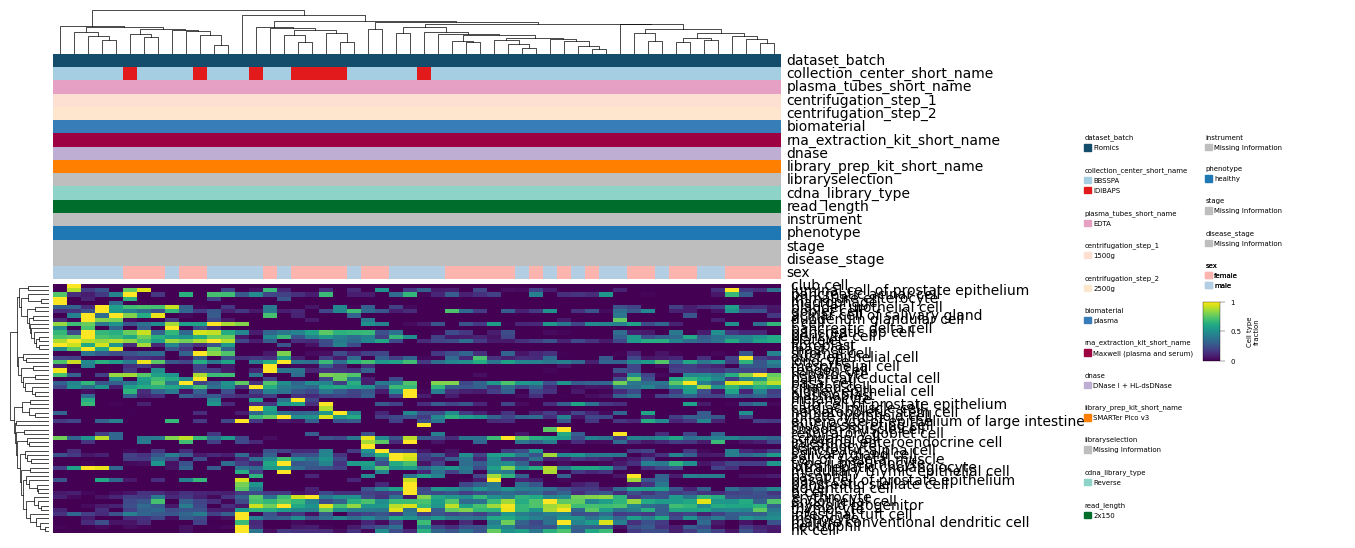

In [69]:
reload(heatmap_plot)

for i in full_list:
    if i in df_dict.keys():
        print(i)
        out_file = "../output/"+i+"/heatmap/all_cell"
        df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
        heatmap_plot.create_heatmap(df_dict[i],
                                               all_cell_list,
                                               meta_list, 
                                               output=out_file,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               remove_all_zero=True,
                                               rescale_values=True,
                                               row_cluster=True)

#### all cell-types (variable filters)

Flomics_2
['b cell', 'erythrocyte', 'platelet']
chalasani_merged
['erythrocyte', 'neutrophil', 'platelet']
chen
['erythrocyte', 'platelet']
ibarra
['erythrocyte', 'monocyte', 'neutrophil', 'platelet']
moufarrej
['erythrocyte', 'platelet']
reggiardo
['erythrocyte', 'macrophage', 'platelet']
roskams
['erythrocyte', 'platelet']
tao
['erythrocyte', 'platelet']
toden
['erythrocyte', 'monocyte', 'platelet']
zhu
['erythrocyte', 'platelet']
decru
['erythrocyte', 'platelet']
['erythrocyte', 'platelet', 'macrophage', 'monocyte', 'neutrophil', 'b cell']
{'dataset_batch': {'Flomics': '#144d6b'}, 'collection_center_short_name': {'BBSSPA': '#A6CEE3', 'IDIBAPS': '#E31A1C'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'1500g': '#FEE0D2'}, 'centrifugation_step_2': {'2500g': '#FEE6CE'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Maxwell (plasma and serum)': '#9E0142'}, 'dnase': {'DNase I + HL-dsDNase': '#BEAED4'}, 'library_prep_kit_short_name':

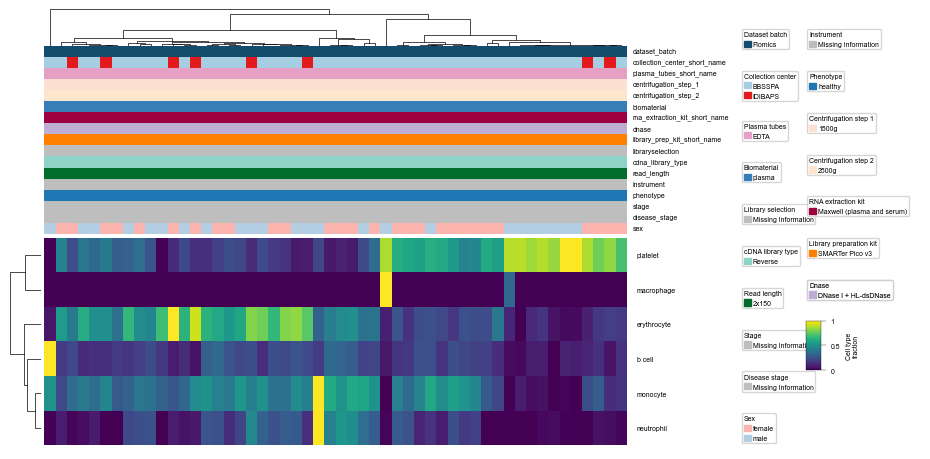

{'dataset_batch': {'Chalasani': '#800040'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE'}, 'plasma_tubes_short_name': {'Vacutainer': '#7294D4'}, 'centrifugation_step_1': {'1900g': '#FC9272'}, 'centrifugation_step_2': {'Missing Information': '#BEBEBE'}, 'biomaterial': {'serum': '#4DAF4A'}, 'rna_extraction_kit_short_name': {'Qiagen QIAamp': '#ABDDA4'}, 'dnase': {'Turbo DNAse': '#386CB0'}, 'library_prep_kit_short_name': {'Unspecified': '#333333'}, 'libraryselection': {'Hybrid Selection': '#1f77b4'}, 'cdna_library_type': {'Unstranded': '#BEBADA'}, 'read_length': {'2x75': '#74C476'}, 'instrument': {'Illumina NextSeq 500': '#1F78B4'}, 'phenotype': {'Missing Information': '#BEBEBE', 'Healthy': '#1F78B4', 'Nonalcoholic fatty liver disease': '#C51B7D', 'Nonalcoholic steatohepatitis': '#E99A6E'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE', 'F0': '#FCFBFD', 'F1': '#EFEDF5', 'F2': '#DADAEB', 'F3': '#BCBDDC', 'F4': '#9E9AC8'}

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 39.68888888888889 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/chalasani_merged/heatmap/all_cell_0.1_0.1.pdf
Heatm

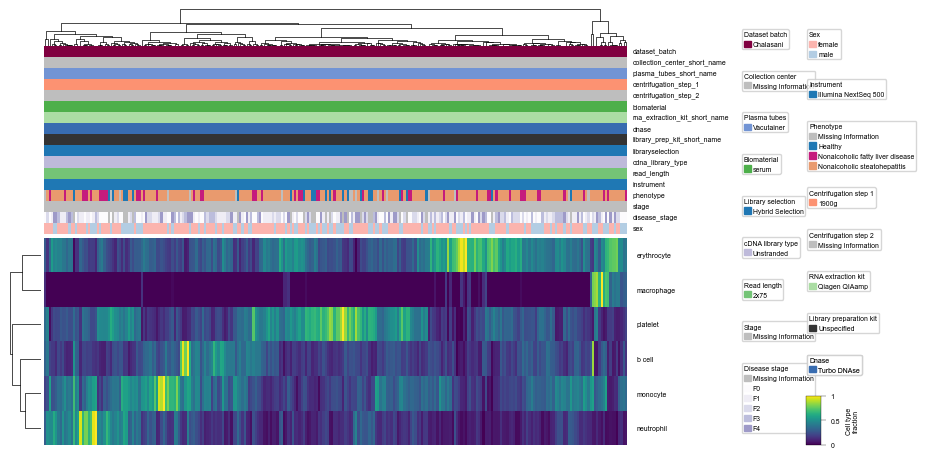

{'dataset_batch': {'Chen': '#997a00'}, 'collection_center_short_name': {'NCC': '#FF7F00', 'PKUFH': '#CAB2D6', 'PUMC': '#6A3D9A', 'SMMU': '#FFFF99', 'SMMU (EHBH)': '#B15928', 'Southwest Hospital': '#FCCDE5'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'Unspecified': '#333333'}, 'centrifugation_step_2': {'Unspecified': '#333333'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Norgen': '#F46D43'}, 'dnase': {'DNase I': '#FDC086'}, 'library_prep_kit_short_name': {'SMARTer Pico v2': '#FDBF6F'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x150': '#006D2C'}, 'instrument': {'Ilumina HiSeq X Ten': '#33A02C'}, 'phenotype': {'Colorectal cancer': '#FFFFB3', 'Esophagus cancer': '#FB8072', 'Healthy': '#1F78B4', 'Liver cancer': '#80B1D3', 'Lung cancer': '#FDB462', 'Stomach cancer': '#BC80BD'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEB

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 36.24930555555555 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1.pdf
Heatmap saved to 

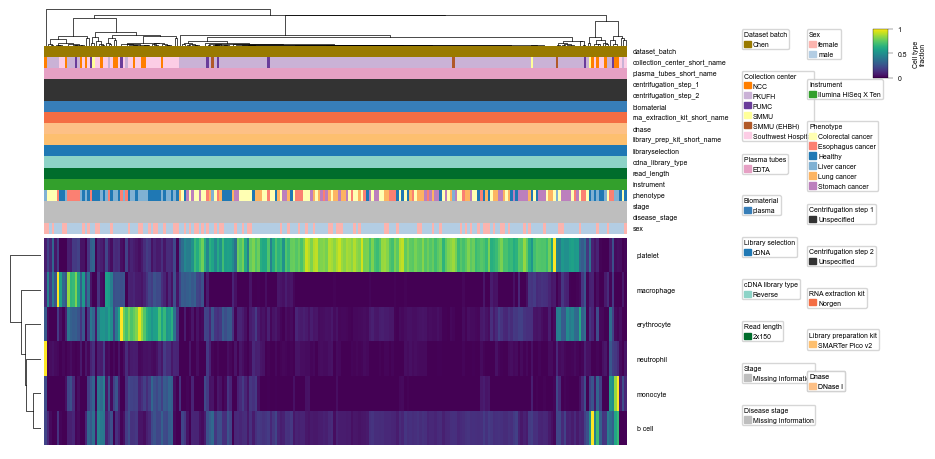

{'dataset_batch': {'Ibarra (buffy coat)': '#800000', 'Ibarra (serum)': '#B22522', 'Ibarra (plasma C)': '#1f77b4', 'Ibarra (plasma NC)': '#17becf'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE', 'San Diego Blood Bank': '#F0027F', 'Scripps': '#666666', 'Scripps (BMT)': '#BF5B17', 'Scripps (CC)': '#6A3D9A'}, 'plasma_tubes_short_name': {'Missing Information': '#BEBEBE'}, 'centrifugation_step_1': {'1900g': '#FC9272'}, 'centrifugation_step_2': {'Missing Information': '#BEBEBE', '16000g': '#8C2D04', '6000g': '#FDAE6B'}, 'biomaterial': {'buffy coat': '#E41A1C', 'plasma': '#377EB8', 'serum': '#4DAF4A'}, 'rna_extraction_kit_short_name': {'Qiagen QIAamp': '#ABDDA4'}, 'dnase': {'Turbo DNAse': '#386CB0'}, 'library_prep_kit_short_name': {'Unspecified': '#333333'}, 'libraryselection': {'unspecified': '#8dd3c7'}, 'cdna_library_type': {'Unstranded': '#BEBADA'}, 'read_length': {'2x75': '#74C476'}, 'instrument': {'Illumina NextSeq 500': '#1F78B4'}, 'phenotype': {'Missing Information'

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 41.981944444444444 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class

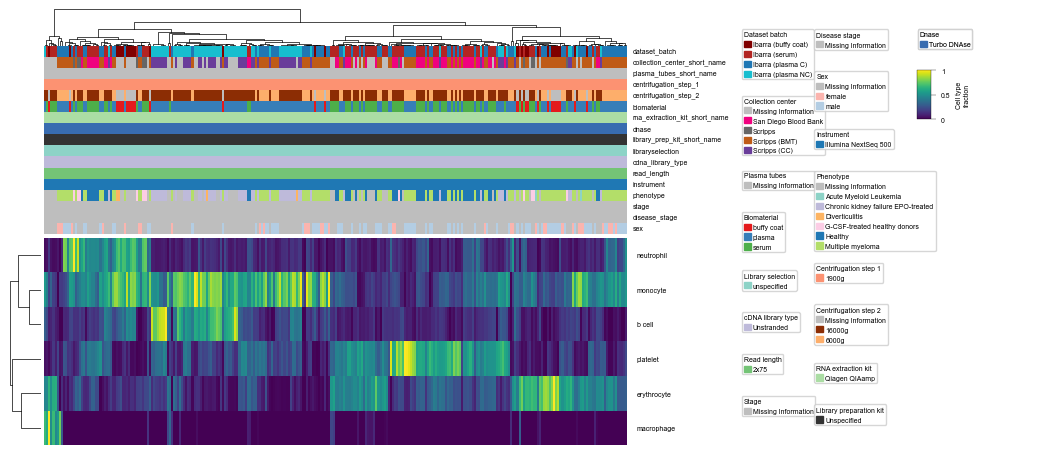

{'dataset_batch': {'Moufarrej (Site 1)': '#CC79A7', 'Moufarrej (Site 2)': '#CC79A7'}, 'collection_center_short_name': {'GAPPS': '#33A02C', 'LPCH': '#FDBF6F'}, 'plasma_tubes_short_name': {'EDTA/Streck': '#C6CDF7'}, 'centrifugation_step_1': {'1600g': '#FCBBA1', '2500g': '#EF3B2C'}, 'centrifugation_step_2': {'Missing Information': '#BEBEBE', '13000g': '#F16913'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Norgen (slurry)': '#FDAE61'}, 'dnase': {'Baseline-ZERO': '#7FC97F'}, 'library_prep_kit_short_name': {'SMARTer Pico v2': '#FDBF6F'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x75': '#74C476'}, 'instrument': {'Illumina NovaSeq 6000': '#B2DF8A'}, 'phenotype': {'Healthy': '#1F78B4', 'Pre-eclampsia': '#C49C94'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'female': '#FBB4AE'}}
Starting plotting..
Starting calculating row orders..
Reordering 

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 36.24930555555555 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/moufarrej/heatmap/all_cell_0.1_0.1.pdf
Heatmap save

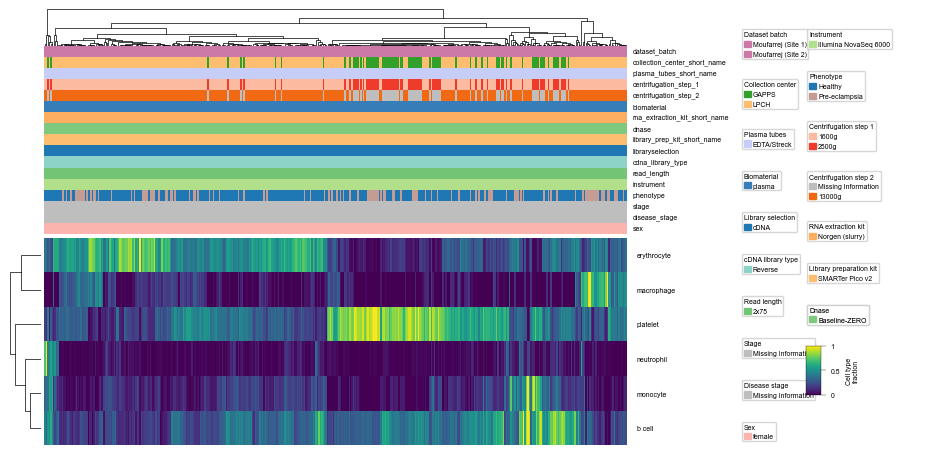

{'dataset_batch': {'Reggiardo (BioIVT)': '#F1085C', 'Reggiardo (DLS)': '#F1085C'}, 'collection_center_short_name': {'BioIVT': '#1F78B4', 'Discovery Life Sciences': '#B2DF8A'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'Unspecified': '#333333'}, 'centrifugation_step_2': {'Unspecified': '#333333'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Qiagen ExoRNeasy': '#FEE08B'}, 'dnase': {'Missing Information': '#BEBEBE'}, 'library_prep_kit_short_name': {'SMART-Seq': '#FB9A99'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Unstranded': '#BEBADA'}, 'read_length': {'2x150': '#006D2C'}, 'instrument': {'Illumina NextSeq 500': '#1F78B4'}, 'phenotype': {'Healthy': '#1F78B4', 'Pancreatic cancer': '#FCCDE5'}, 'stage': {'Missing Information': '#BEBEBE', 'I-B': '#F8826F', 'II-B': '#FB6A4A', 'III': '#EF3B2C', 'IV': '#CB181D'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'Missing Information': '#BEBEBE'}}
Start

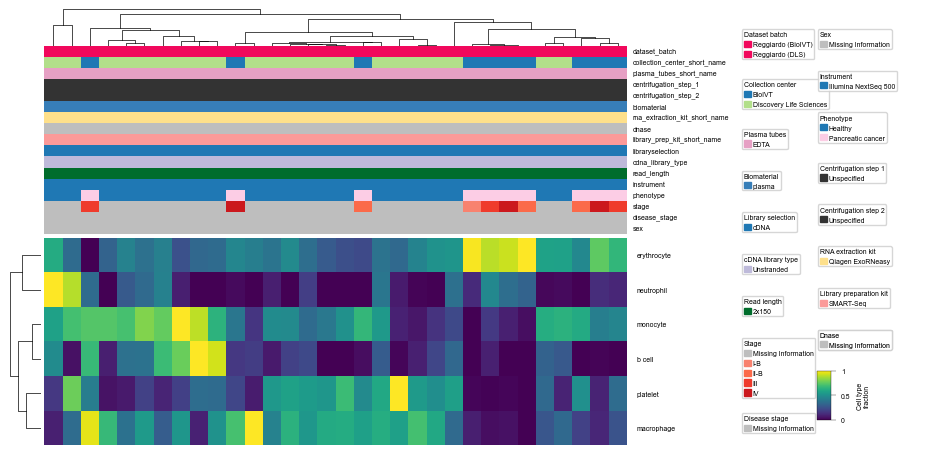

{'dataset_batch': {'Roskams (pilot)': '#1f77b4', 'Roskams (validation)': '#17becf'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'1000g': '#FFF5F0'}, 'centrifugation_step_2': {'15000g': '#D94801'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Norgen': '#F46D43'}, 'dnase': {'Baseline-ZERO': '#7FC97F'}, 'library_prep_kit_short_name': {'SMARTer Pico v2': '#FDBF6F'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x100': '#31A354', '2x150': '#006D2C'}, 'instrument': {'Illumina HiSeq 4000': '#A6CEE3'}, 'phenotype': {'Healthy': '#1F78B4', 'Liver cancer': '#80B1D3', 'Multiple myeloma': '#B3DE69', 'Pre-cancerous condition: MGUS': '#98DF8A', 'Pre-cancerous condition: cirrhosis': '#FF9896'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'female': '#FBB4AE', 

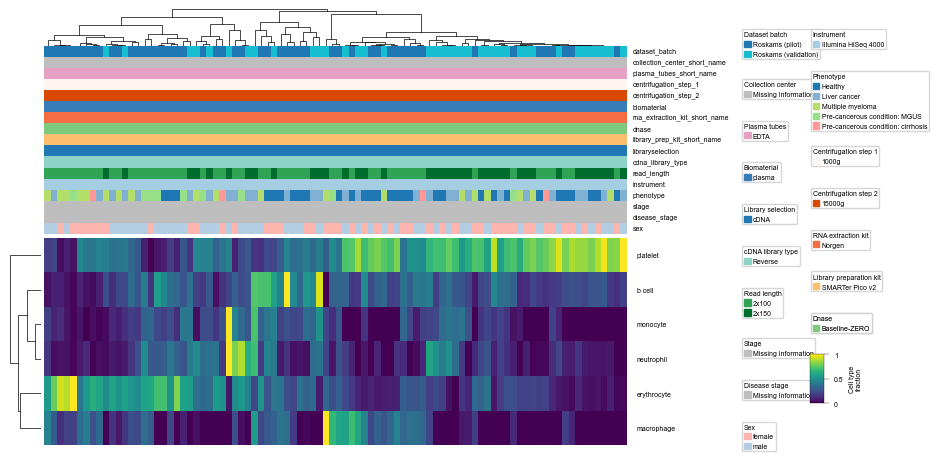

{'dataset_batch': {'Tao': '#0072B2'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE'}, 'plasma_tubes_short_name': {'EDTA': '#E6A0C4'}, 'centrifugation_step_1': {'Unspecified': '#333333'}, 'centrifugation_step_2': {'Unspecified': '#333333'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Norgen': '#F46D43'}, 'dnase': {'DNase I': '#FDC086'}, 'library_prep_kit_short_name': {'SMARTer Pico v2': '#FDBF6F'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x150': '#006D2C'}, 'instrument': {'Ilumina HiSeq X Ten': '#33A02C'}, 'phenotype': {'Colorectal cancer': '#FFFFB3', 'Healthy': '#1F78B4', 'Stomach cancer': '#BC80BD'}, 'stage': {'1': '#DEEBF7', '1A': '#C6DBEF', '1B': '#9ECAE1', '2A': '#6BAED6', '2B': '#4292C6', '2C': '#2171B5', '3': '#08519C', '3A': '#084594', '3B': '#05317B', '3C': '#032152', '4': '#021029', 'No stage (healthy donor)': '#D9F0A3'}, 'disease_stage': {'Missing Information': '#BE

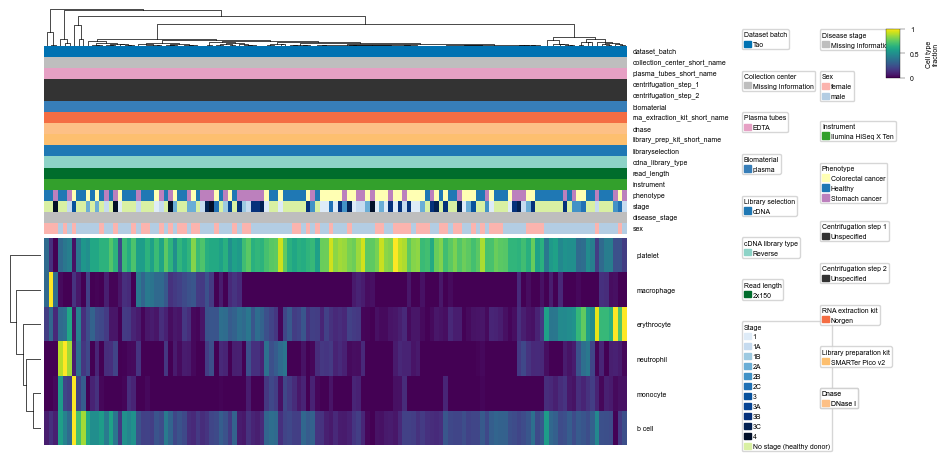

{'dataset_batch': {'Toden': '#800099'}, 'collection_center_short_name': {'BioIVT': '#1F78B4', 'GEMs (Indiana)': '#FB9A99', 'UCSD': '#BC80BD', 'UKY': '#CCEBC5', 'Unknown': '#333333', 'WashU': '#FFED6F'}, 'plasma_tubes_short_name': {'Unspecified': '#333333'}, 'centrifugation_step_1': {'12000g': '#67000D'}, 'centrifugation_step_2': {'Missing Information': '#BEBEBE'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Qiagen QIAamp': '#ABDDA4'}, 'dnase': {'Missing Information': '#BEBEBE'}, 'library_prep_kit_short_name': {'Swift 2S kit ': '#CAB2D6'}, 'libraryselection': {'Hybrid Selection': '#1f77b4'}, 'cdna_library_type': {'Unstranded': '#BEBADA'}, 'read_length': {'2x75': '#74C476'}, 'instrument': {'Illumina NextSeq 500': '#1F78B4'}, 'phenotype': {'Missing Information': '#BEBEBE', 'Alzheimers disease': '#FFFFB3', 'Healthy': '#1F78B4'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'Missing Information': '#BEB

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 36.24930555555555 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/toden/heatmap/all_cell_0.1_0.1.pdf
Heatmap saved to

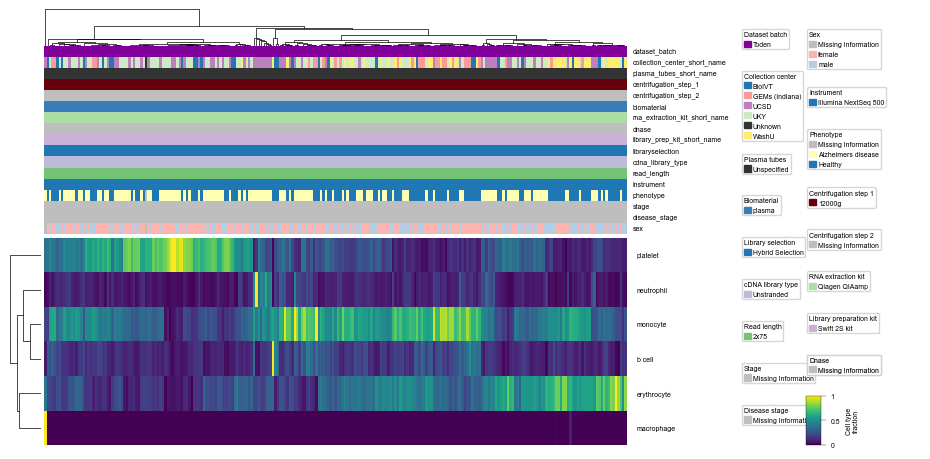

{'dataset_batch': {'Zhu': '#ffd633'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE'}, 'plasma_tubes_short_name': {'Unspecified': '#333333'}, 'centrifugation_step_1': {'Unspecified': '#333333'}, 'centrifugation_step_2': {'Unspecified': '#333333'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Norgen': '#F46D43'}, 'dnase': {'DNase I': '#FDC086'}, 'library_prep_kit_short_name': {'SMARTer Pico v2': '#FDBF6F'}, 'libraryselection': {'cDNA': '#1F78B4'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x150': '#006D2C'}, 'instrument': {'Ilumina HiSeq X Ten': '#33A02C'}, 'phenotype': {'Healthy': '#1F78B4', 'Liver cancer': '#80B1D3'}, 'stage': {'Missing Information': '#BEBEBE', '0': '#F7FBFF', 'A': '#FEE0D2', 'B': '#FCBBA1', 'C': '#FC9272'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'female': '#FBB4AE', 'male': '#B3CDE3'}}
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating co

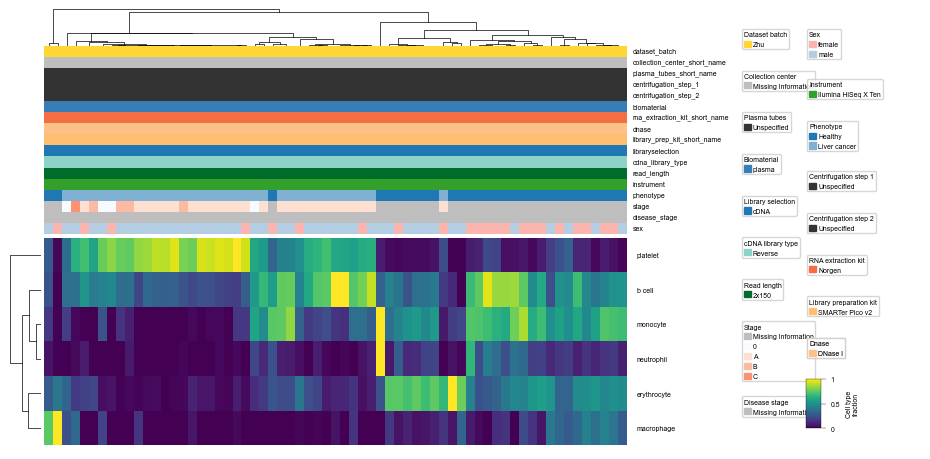

{'dataset_batch': {'Decruyenaere': '#009E73'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE'}, 'plasma_tubes_short_name': {'PAXgene blood ccfDNA': '#D8A499'}, 'centrifugation_step_1': {'1900g': '#FC9272'}, 'centrifugation_step_2': {'Missing Information': '#BEBEBE'}, 'biomaterial': {'plasma': '#377EB8'}, 'rna_extraction_kit_short_name': {'Qiagen miRNeasy Plasma': '#E6F598'}, 'dnase': {'HL-dsDNase': '#FFFF99'}, 'library_prep_kit_short_name': {'SMARTer Pico v3': '#FF7F00'}, 'libraryselection': {'Missing Information': '#BEBEBE'}, 'cdna_library_type': {'Reverse': '#8DD3C7'}, 'read_length': {'2x100': '#31A354'}, 'instrument': {'Illumina NovaSeq 6000': '#B2DF8A'}, 'phenotype': {'Diffuse large B-cell lymphoma': '#BEBADA', 'Healthy': '#1F78B4', 'Primary mediastinal B-cell lymphoma': '#D9D9D9'}, 'stage': {'Missing Information': '#BEBEBE'}, 'disease_stage': {'Missing Information': '#BEBEBE'}, 'sex': {'Missing Information': '#BEBEBE'}}
Starting plotting..
Starting calculating r

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 43.12847222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matplotlib.legend.Legend'>
12
<class 'matplotlib.legend.Legend'>
13
<class 'matplotlib.legend.Legend'>
14
<class 'matplotlib.legend.Legend'>
15
<class 'matplotlib.legend.Legend'>
16
<class 'matplotlib.legend.Legend'>
17
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/decru/heatmap/all_cell_0.1_0.1.pdf
Heatmap saved to

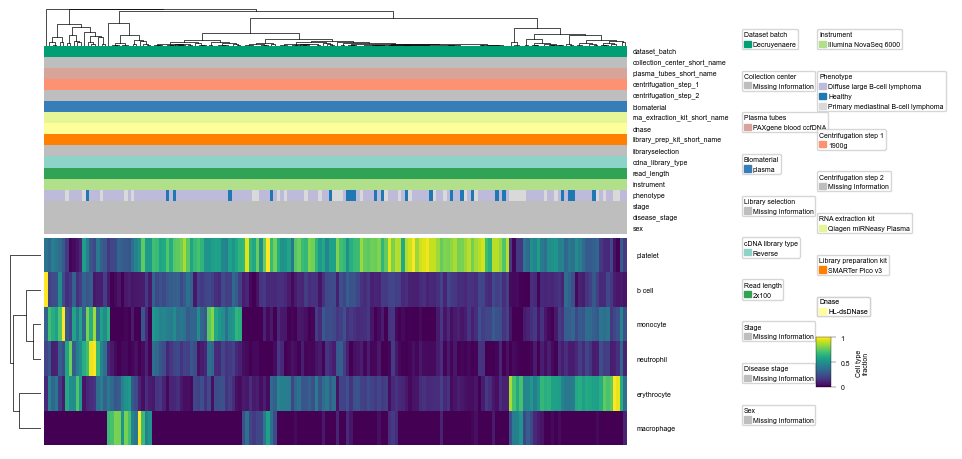

In [100]:
reload(heatmap_plot)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    print(i)
    print(filtered_value_columns)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)

for i in full_list:
    if i in df_dict.keys():
        out_file = "../output/"+i+"/heatmap/all_cell_0.1_0.1"
        df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
        cm, final_data, final_color =  heatmap_plot.create_heatmap(df_dict[i],
                            selected_columns,
                                               meta_list,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               min_relative_abundance=0,
                                               min_sample_percentage=0,
                                               remove_all_zero=True,
                                               row_cluster=True,
                                               rescale_values=True,
                                               row_height = 6,
                                               output=out_file,
                                               fig_height_inc = 5,
                                               fig_width_inc = 8,
                                               show_legend = True,
                                               heatmap_label_fontsize = 5,
                                               heatmap_value_name = "Cell type\nfraction",
                                               annotation_fontsize = 5,
                                               legend_vpad=-55,
                                               legend_hpad = 10,
                                               legend_gap = 8,
                                               legend_border = True,
                                               legend_order = legend_order,
                                               legend_rename = legend_rename)




        

#### all cell-types (MCTs) ~ specific for Chen

Flomics_2
['b cell', 'erythrocyte', 'platelet']
chalasani_merged
['erythrocyte', 'neutrophil', 'platelet']
chen
['erythrocyte', 'platelet']
ibarra
['erythrocyte', 'monocyte', 'neutrophil', 'platelet']
moufarrej
['erythrocyte', 'platelet']
reggiardo
['erythrocyte', 'macrophage', 'platelet']
roskams
['erythrocyte', 'platelet']
tao
['erythrocyte', 'platelet']
toden
['erythrocyte', 'monocyte', 'platelet']
zhu
['erythrocyte', 'platelet']
decru
['erythrocyte', 'platelet']
['erythrocyte', 'platelet', 'macrophage', 'monocyte', 'neutrophil', 'b cell']
{'collection_center': {'NCC': '#1f77b4', 'PKUFH': '#2ca02c', 'PUMC': '#9467bd', 'SMMU': '#e377c2', 'SMMU (EHBH)': '#bcbd22', 'Southwest Hospital': '#17becf'}, 'phenotype': {'Colorectal cancer': '#FFFFB3', 'Esophagus cancer': '#FB8072', 'Healthy': '#1F78B4', 'Liver cancer': '#80B1D3', 'Lung cancer': '#FDB462', 'Stomach cancer': '#BC80BD'}}
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reor

/tmp/ipykernel_4558/3845637148.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering la

Starting plotting HeatmapAnnotations
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1.pdf
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1.png
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1.svg


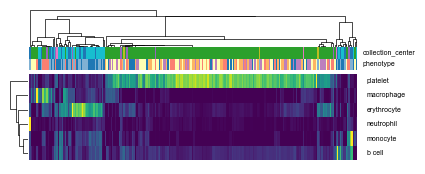

In [74]:
reload(heatmap_plot)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    print(i)
    print(filtered_value_columns)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)



i = "chen"

chen_data = df_dict[i]
chen_data["collection_center"] = chen_data["collection_center_short_name"]

out_file = "../output/"+i+"/heatmap/all_cell_0.1_0.1"
df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)

meta_list = ["collection_center",
             "phenotype"]

cm, final_data, final_color =  heatmap_plot.create_heatmap(df_dict[i],
                            selected_columns,
                                               meta_list,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               min_relative_abundance=0,
                                               min_sample_percentage=0,
                                               remove_all_zero=True,
                                               row_cluster=True,
                                               rescale_values=True,
                                               row_height = 2,
                                               output=out_file,
                                               fig_height_inc = 2,
                                               fig_width_inc = 4.5,
                                               show_legend = False,
                                               heatmap_label_fontsize = 5,
                                               annotation_fontsize = 5)

#### all cell-types (variable filters) ~ specific for Chen (with legends)

Flomics_2
['b cell', 'erythrocyte', 'platelet']
chalasani_merged
['erythrocyte', 'neutrophil', 'platelet']
chen
['erythrocyte', 'platelet']
ibarra
['erythrocyte', 'monocyte', 'neutrophil', 'platelet']
moufarrej
['erythrocyte', 'platelet']
reggiardo
['erythrocyte', 'macrophage', 'platelet']
roskams
['erythrocyte', 'platelet']
tao
['erythrocyte', 'platelet']
toden
['erythrocyte', 'monocyte', 'platelet']
zhu
['erythrocyte', 'platelet']
decru
['erythrocyte', 'platelet']
['erythrocyte', 'platelet', 'macrophage', 'monocyte', 'neutrophil', 'b cell']
{'collection_center': {'NCC': '#1f77b4', 'PKUFH': '#2ca02c', 'PUMC': '#9467bd', 'SMMU': '#e377c2', 'SMMU (EHBH)': '#bcbd22', 'Southwest Hospital': '#17becf'}, 'phenotype': {'Colorectal cancer': '#FFFFB3', 'Esophagus cancer': '#FB8072', 'Healthy': '#1F78B4', 'Liver cancer': '#80B1D3', 'Lung cancer': '#FDB462', 'Stomach cancer': '#BC80BD'}}
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reor

/tmp/ipykernel_4558/3642889463.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering la

Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 23.6375 mm
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.colorbar.Colorbar'>
<class 'matplotlib.colorbar.Colorbar'>
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1_legend.pdf
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1_legend.png
Heatmap saved to output/chen/heatmap/all_cell_0.1_0.1_legend.svg


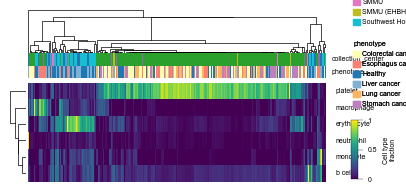

In [72]:
reload(heatmap_plot)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    print(i)
    print(filtered_value_columns)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)



i = "chen"

chen_data = df_dict[i]
chen_data["collection_center"] = chen_data["collection_center_short_name"]

out_file = "../output/"+i+"/heatmap/all_cell_0.1_0.1_legend"
df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)

meta_list = ["collection_center",
             "phenotype"]

cm, final_data, final_color =  heatmap_plot.create_heatmap(df_dict[i],
                            selected_columns,
                                               meta_list,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               min_relative_abundance=0,
                                               min_sample_percentage=0,
                                               remove_all_zero=True,
                                               row_cluster=True,
                                               rescale_values=True,
                                               row_height = 2,
                                               output=out_file,
                                               fig_height_inc = 2,
                                               fig_width_inc = 4.1,
                                               show_legend = True,
                                               heatmap_label_fontsize = 5,
                                               annotation_fontsize = 5)


#### only blood cells

Flomics_1
Info: Removed the following value columns as they contain all zero values: hematopoietic stem cell, mast cell, plasma cell
Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


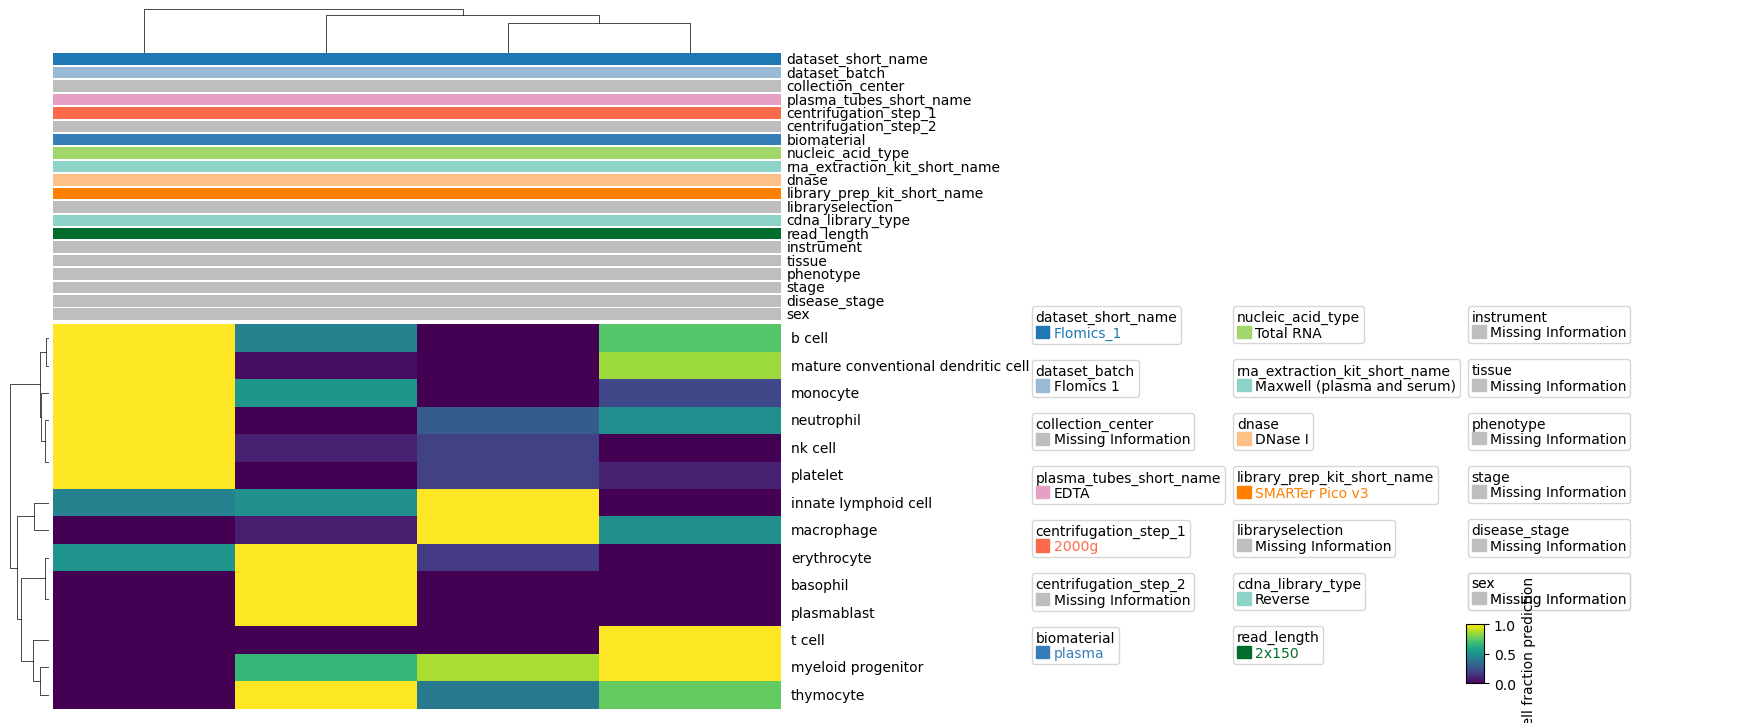

Heatmap saved to output/Flomics_1/heatmap/only_blood.pdf and output/Flomics_1/heatmap/only_blood.png
Flomics_2
Info: Removed the following value columns as they contain all zero values: plasma cell
Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


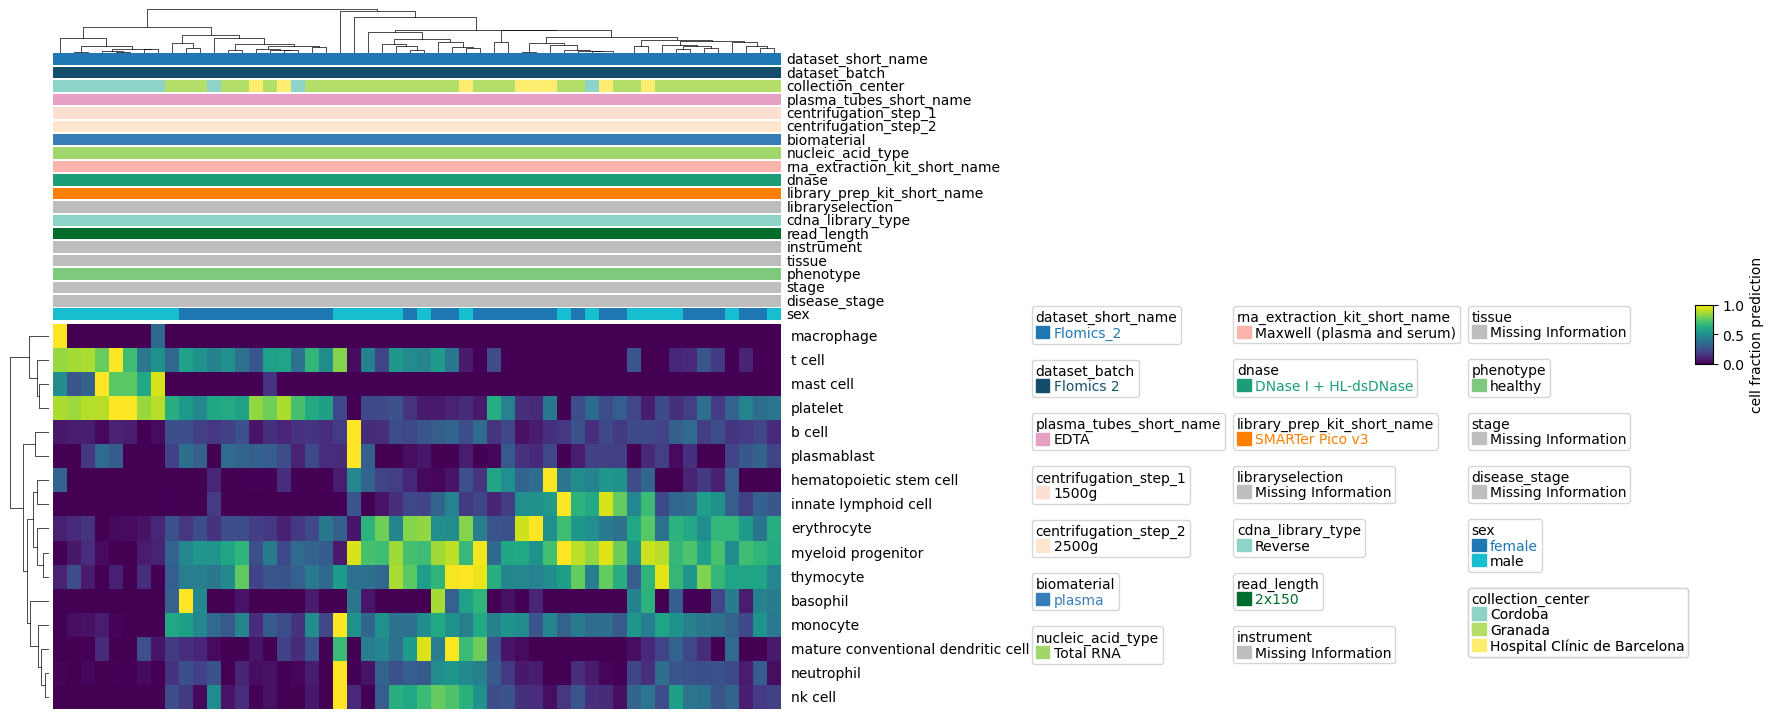

Heatmap saved to output/Flomics_2/heatmap/only_blood.pdf and output/Flomics_2/heatmap/only_blood.png
chalasani_merged
Info: Removed the following value columns as they contain all zero values: mast cell, plasma cell


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


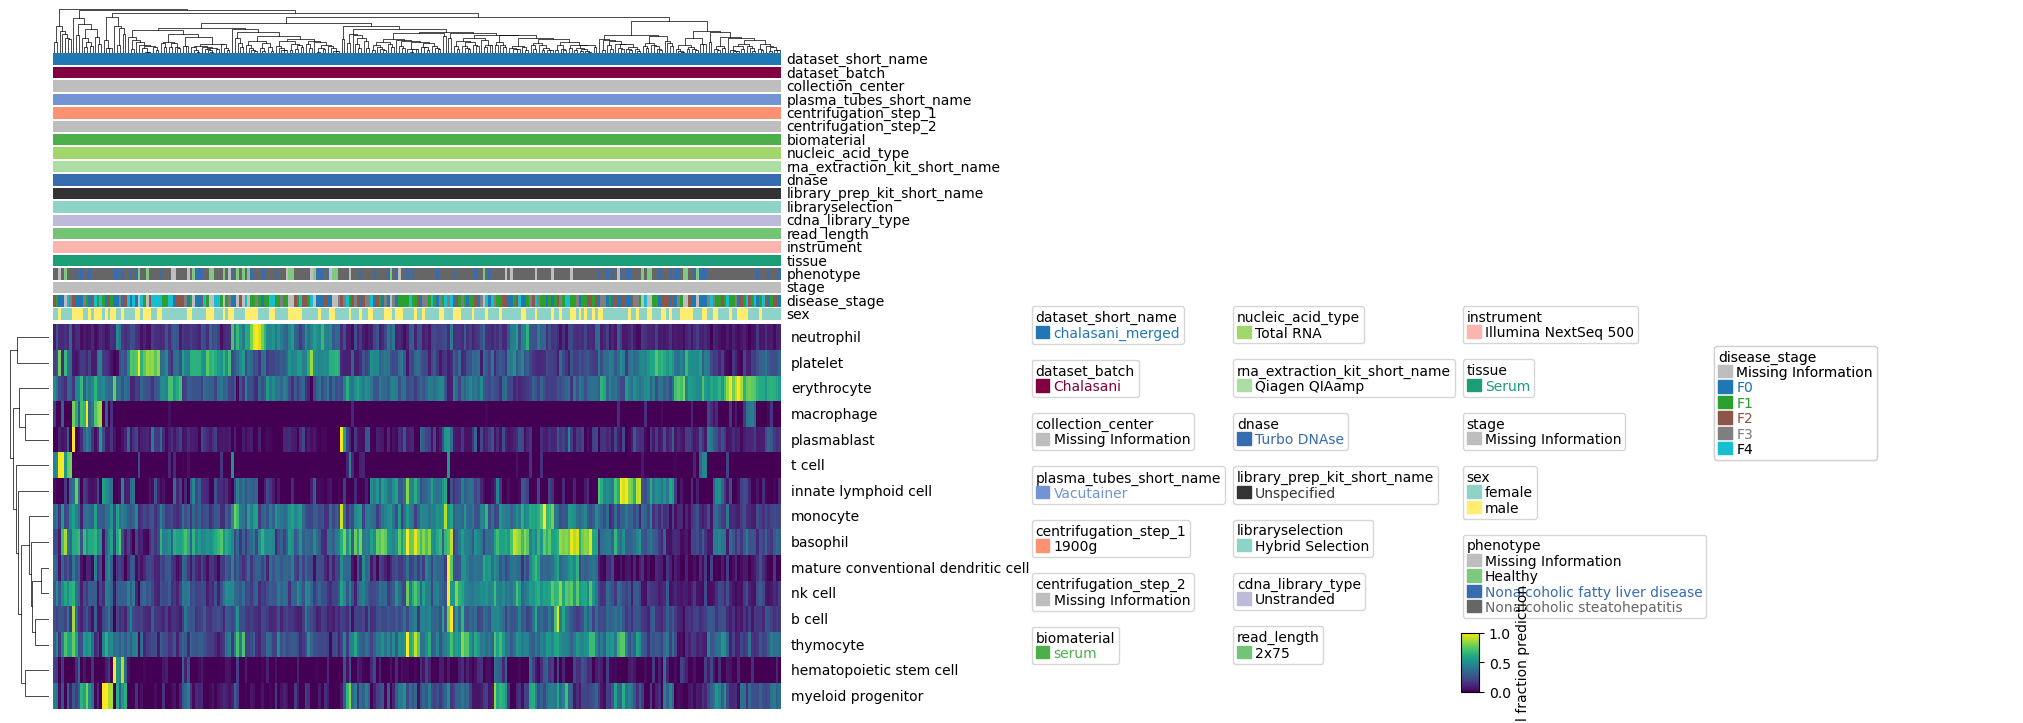

Heatmap saved to output/chalasani_merged/heatmap/only_blood.pdf and output/chalasani_merged/heatmap/only_blood.png
chen


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


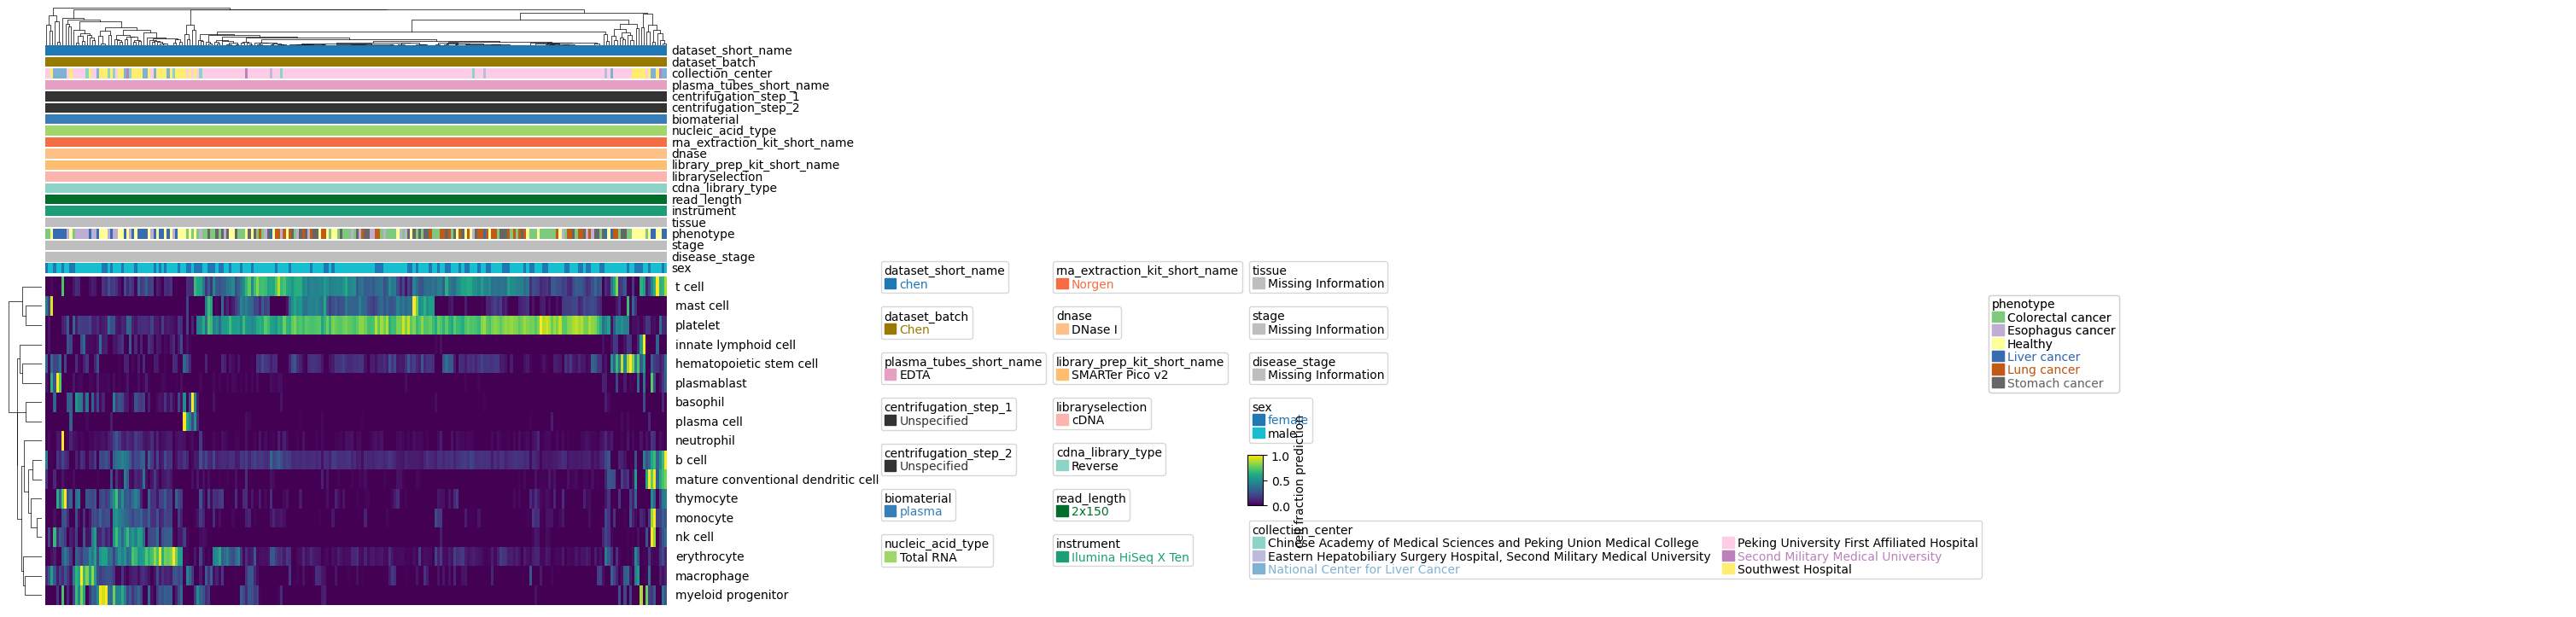

Heatmap saved to output/chen/heatmap/only_blood.pdf and output/chen/heatmap/only_blood.png
ibarra


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


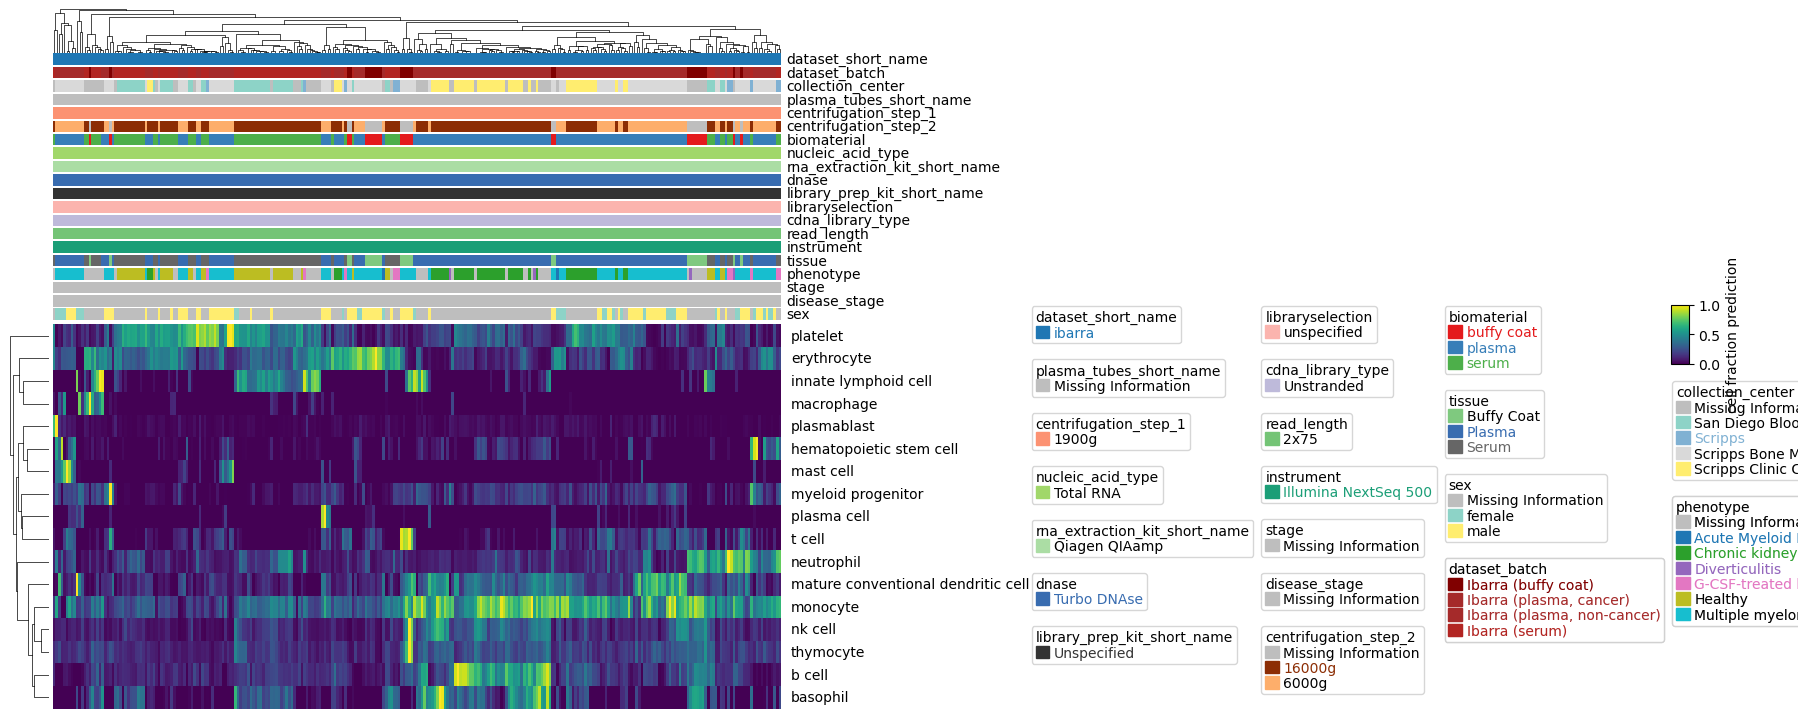

Heatmap saved to output/ibarra/heatmap/only_blood.pdf and output/ibarra/heatmap/only_blood.png
moufarrej


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


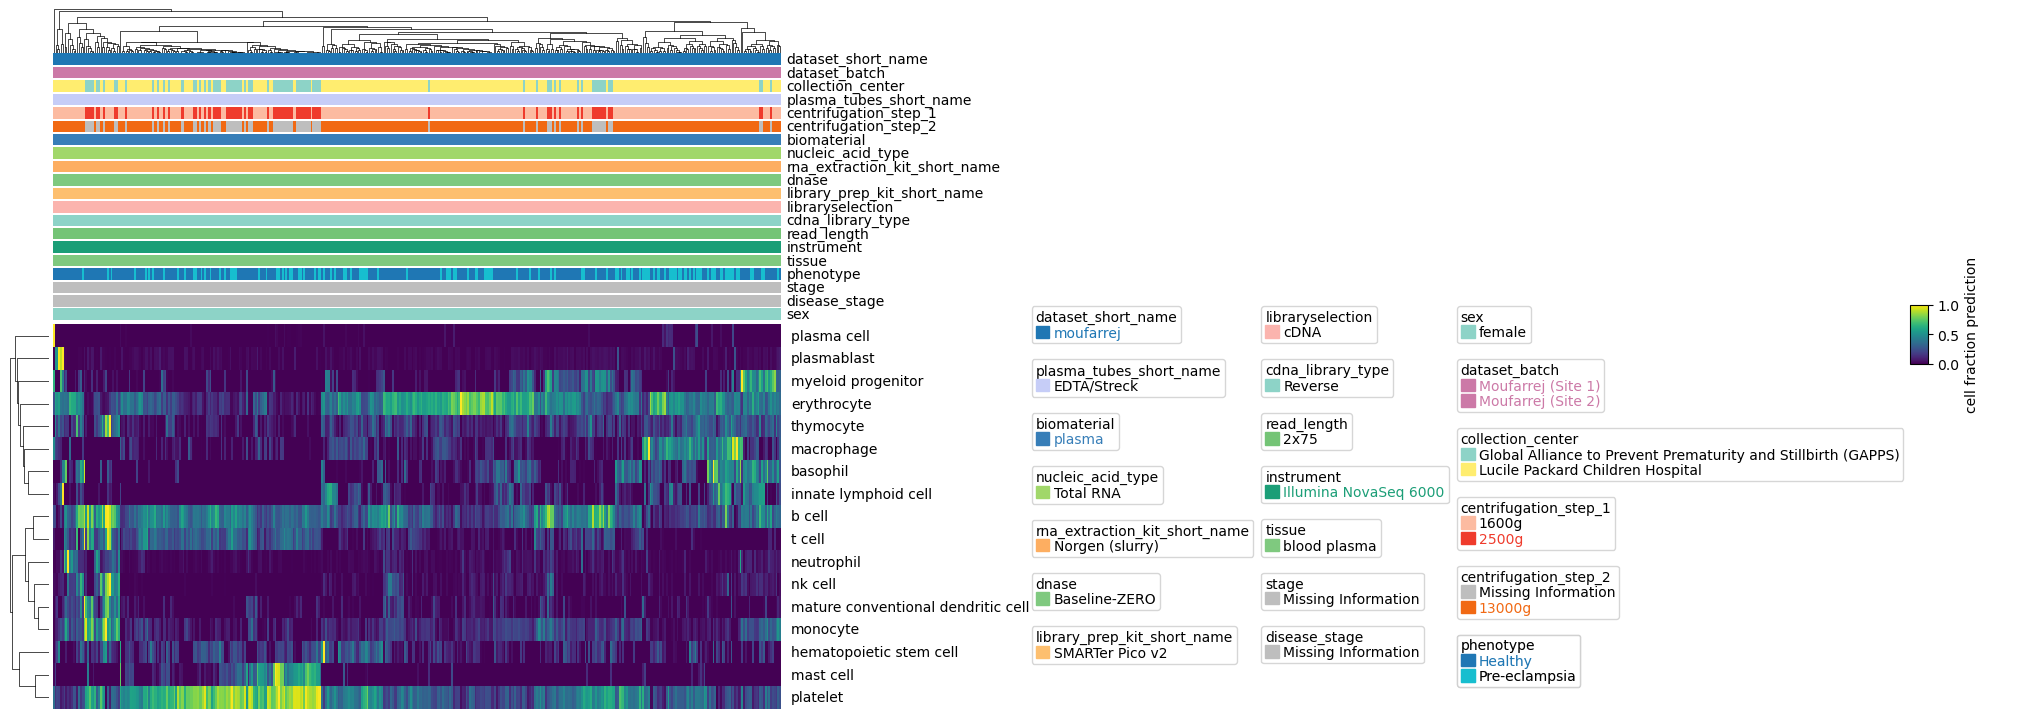

Heatmap saved to output/moufarrej/heatmap/only_blood.pdf and output/moufarrej/heatmap/only_blood.png
reggiardo
Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


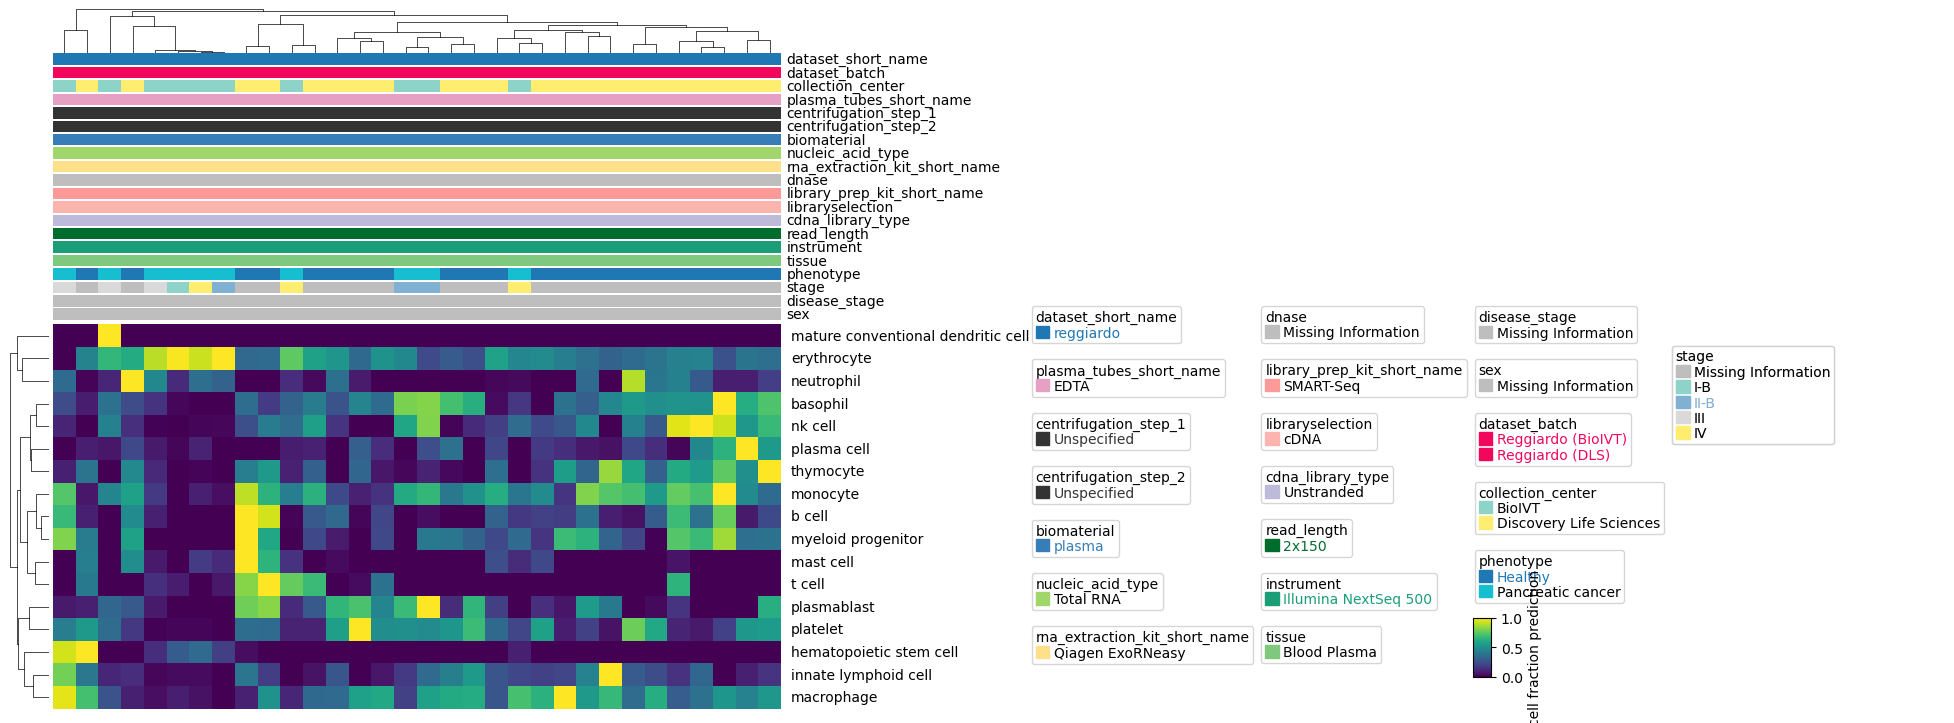

Heatmap saved to output/reggiardo/heatmap/only_blood.pdf and output/reggiardo/heatmap/only_blood.png
roskams


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


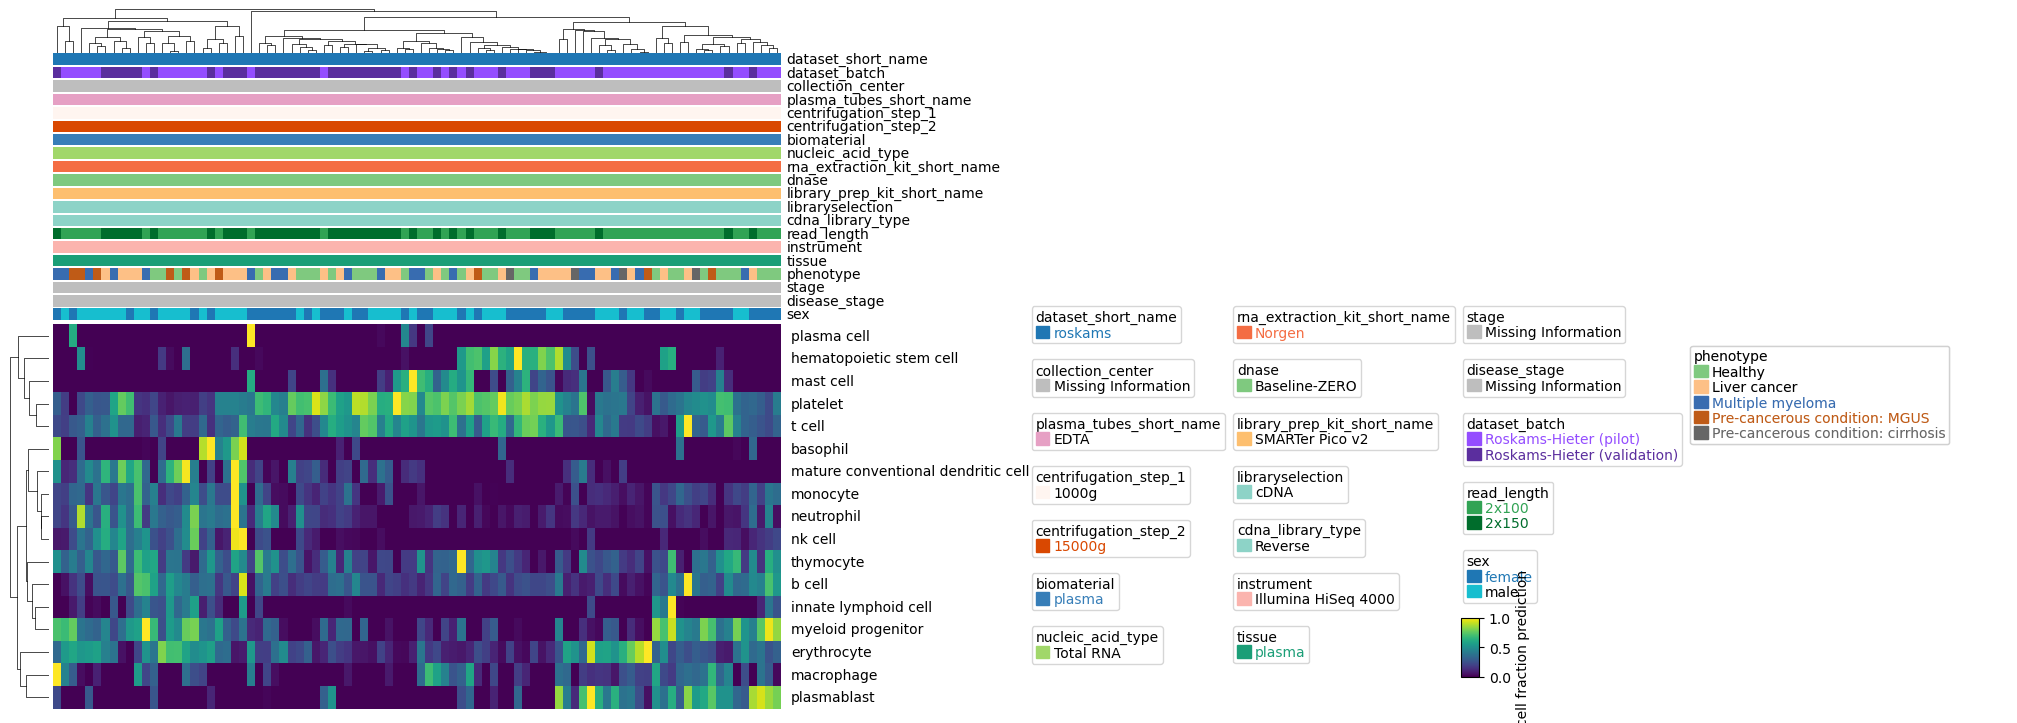

Heatmap saved to output/roskams/heatmap/only_blood.pdf and output/roskams/heatmap/only_blood.png
tao


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


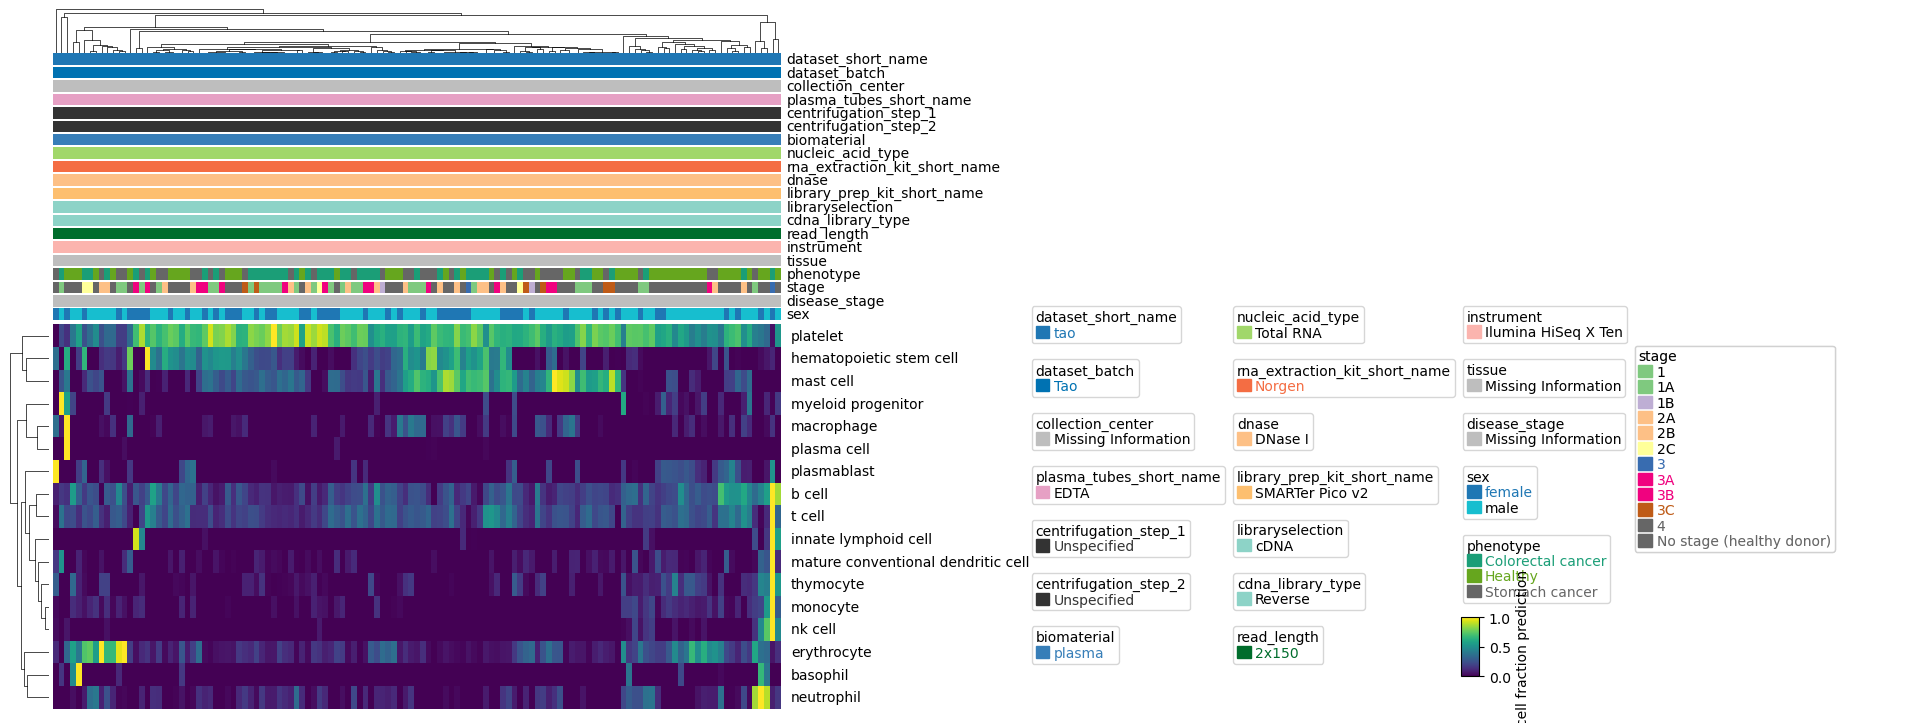

Heatmap saved to output/tao/heatmap/only_blood.pdf and output/tao/heatmap/only_blood.png
toden


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


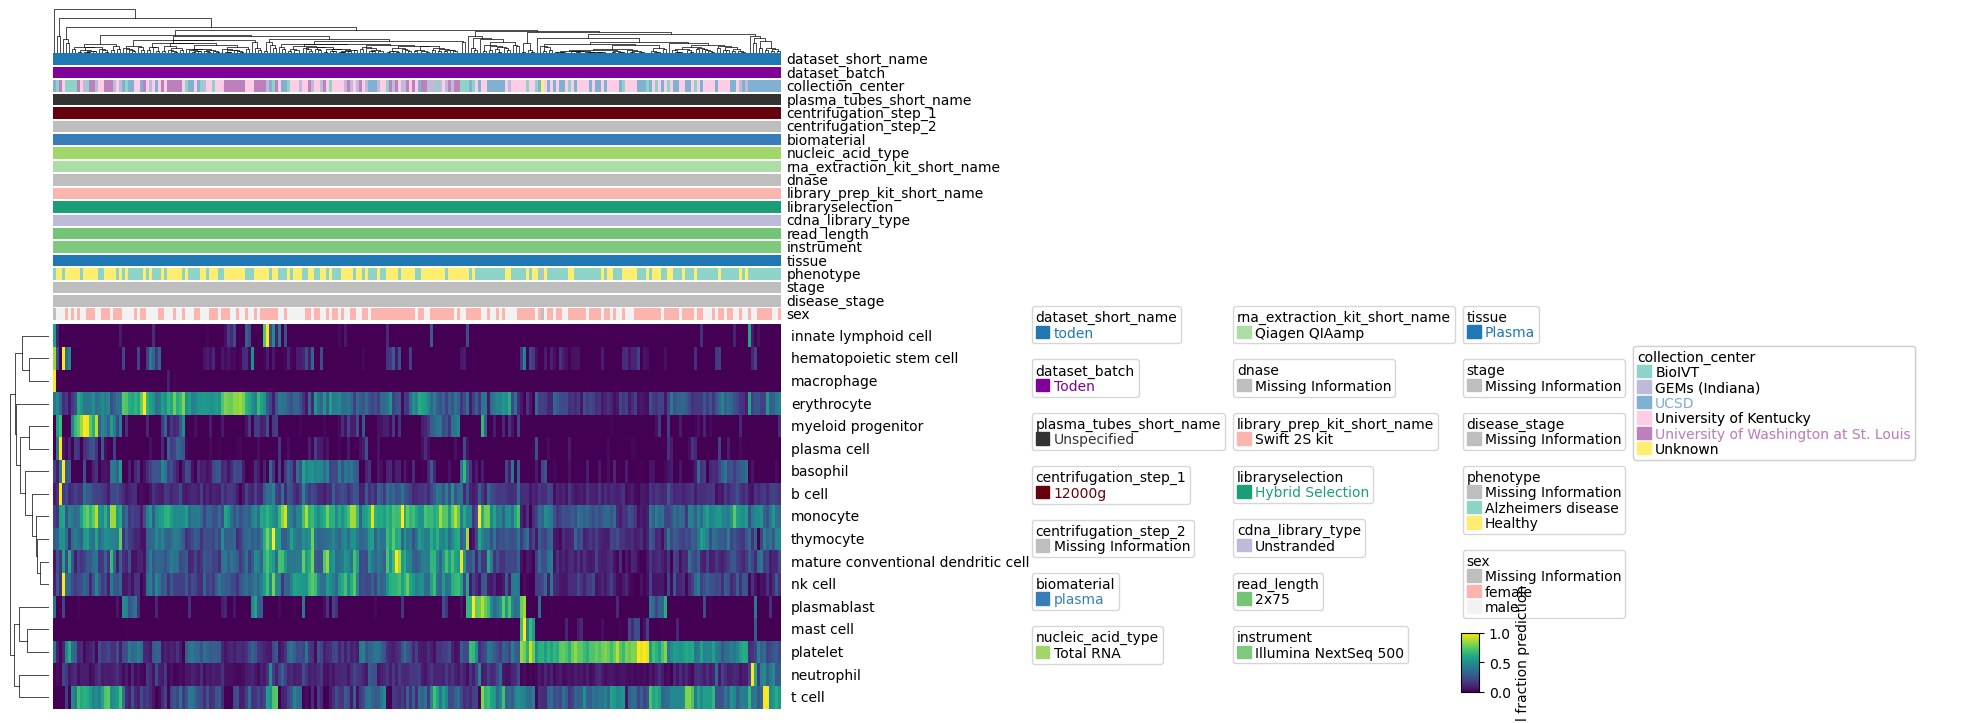

Heatmap saved to output/toden/heatmap/only_blood.pdf and output/toden/heatmap/only_blood.png
zhu


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


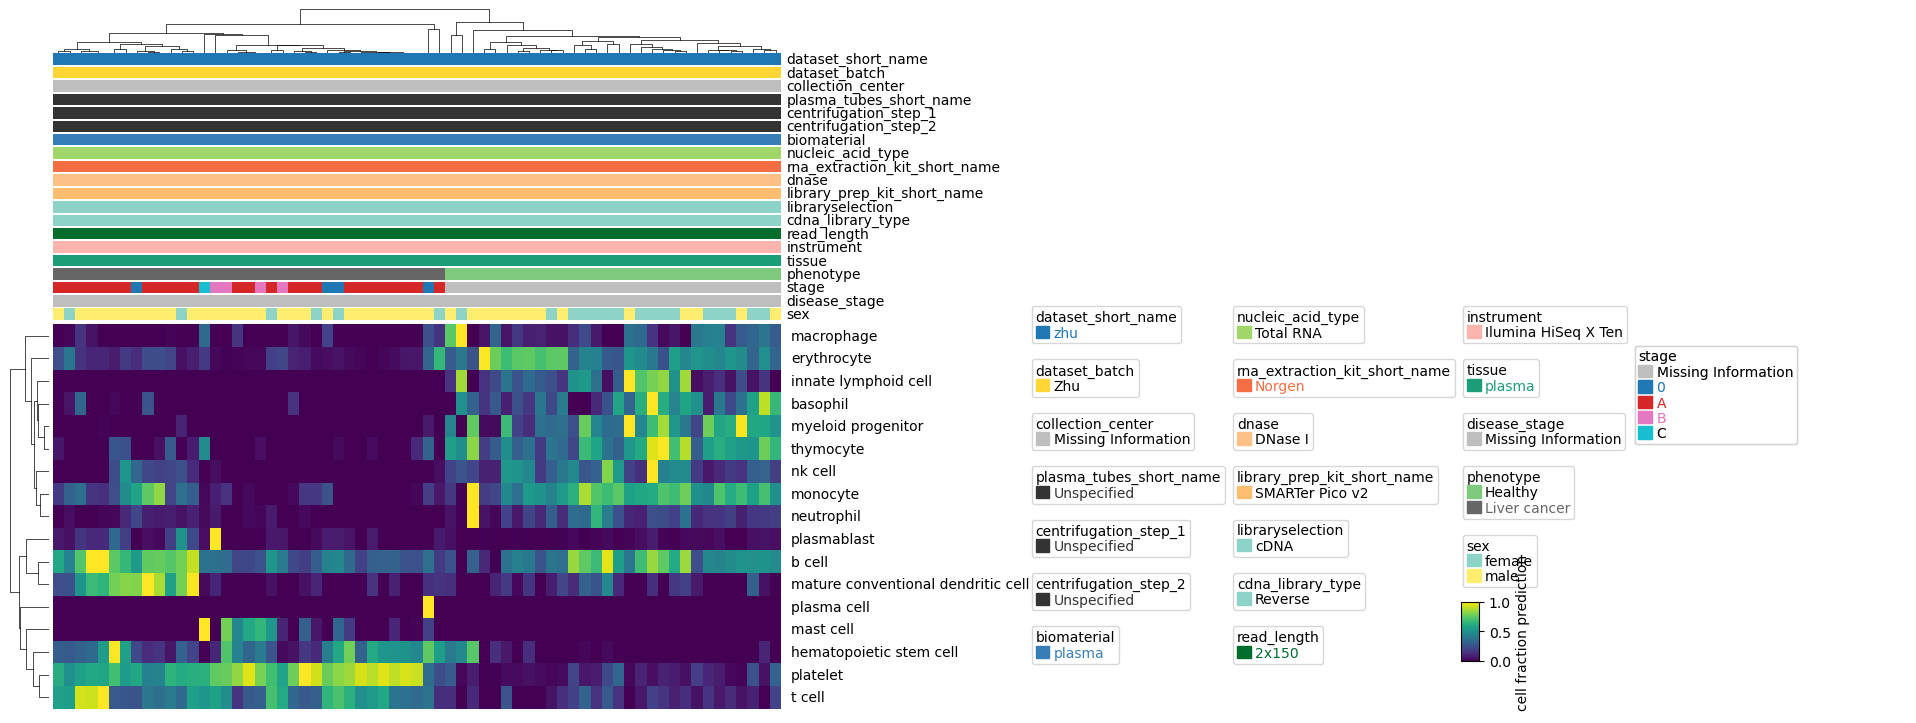

Heatmap saved to output/zhu/heatmap/only_blood.pdf and output/zhu/heatmap/only_blood.png
decru


/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

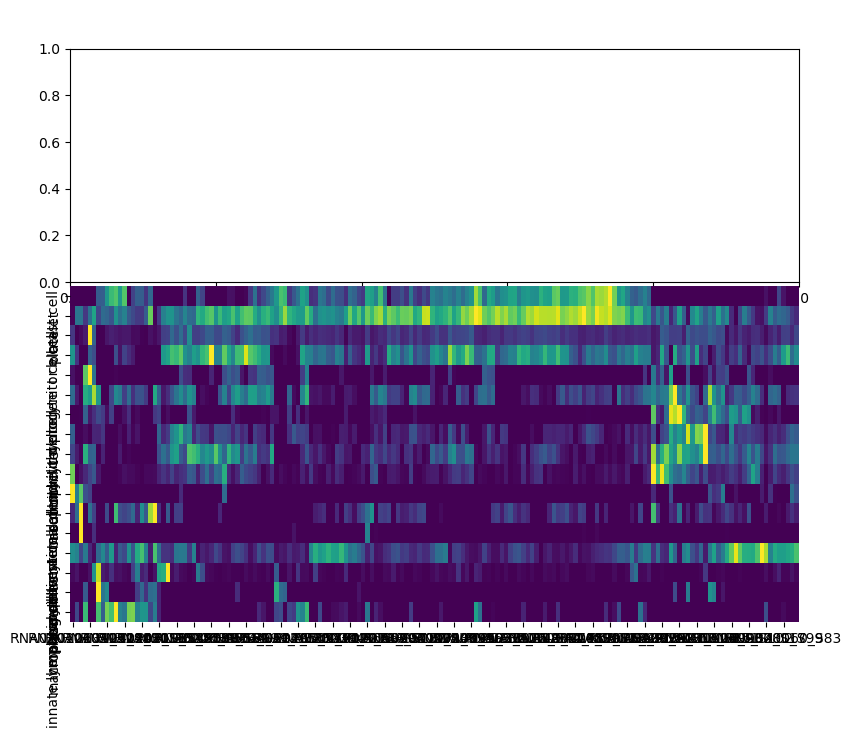

In [134]:
for i in full_list:
    if i in df_dict.keys():
        print(i)
        out_file = "../output/"+i+"/heatmap/only_blood"
        df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
        heatmap_plot.create_heatmap(df_dict[i],
                                               blood_cells,
                                               meta_list,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               remove_all_zero=True,
                                               rescale_values=True,
                                               row_cluster=True,
                                               output=out_file)

#### no blood cells

In [ ]:
for i in full_list:
    if i in df_dict.keys():
        out_file = "output/"+i+"/heatmap/no_blood"
        df_dict[i]["dataset_batch"].replace(data_mapping, inplace=True)
        heatmap_plot.create_heatmap(df_dict[i],
                                               no_blood_cells,
                                               meta_list,
                                               metadata_colors_mapping = heatmap_color_dict,
                                               remove_all_zero=True,
                                               rescale_values=True,
                                               row_cluster=True,
                                               output=out_file)

## PLOTS FOR MERGED DATASETS

### heatmaps

In [85]:
unique_dataset["dataset_batch"].replace(data_mapping, inplace=True)

/tmp/ipykernel_4035/1548337531.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unique_dataset["dataset_batch"].replace(data_mapping, inplace=True)


#### all cell-types

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


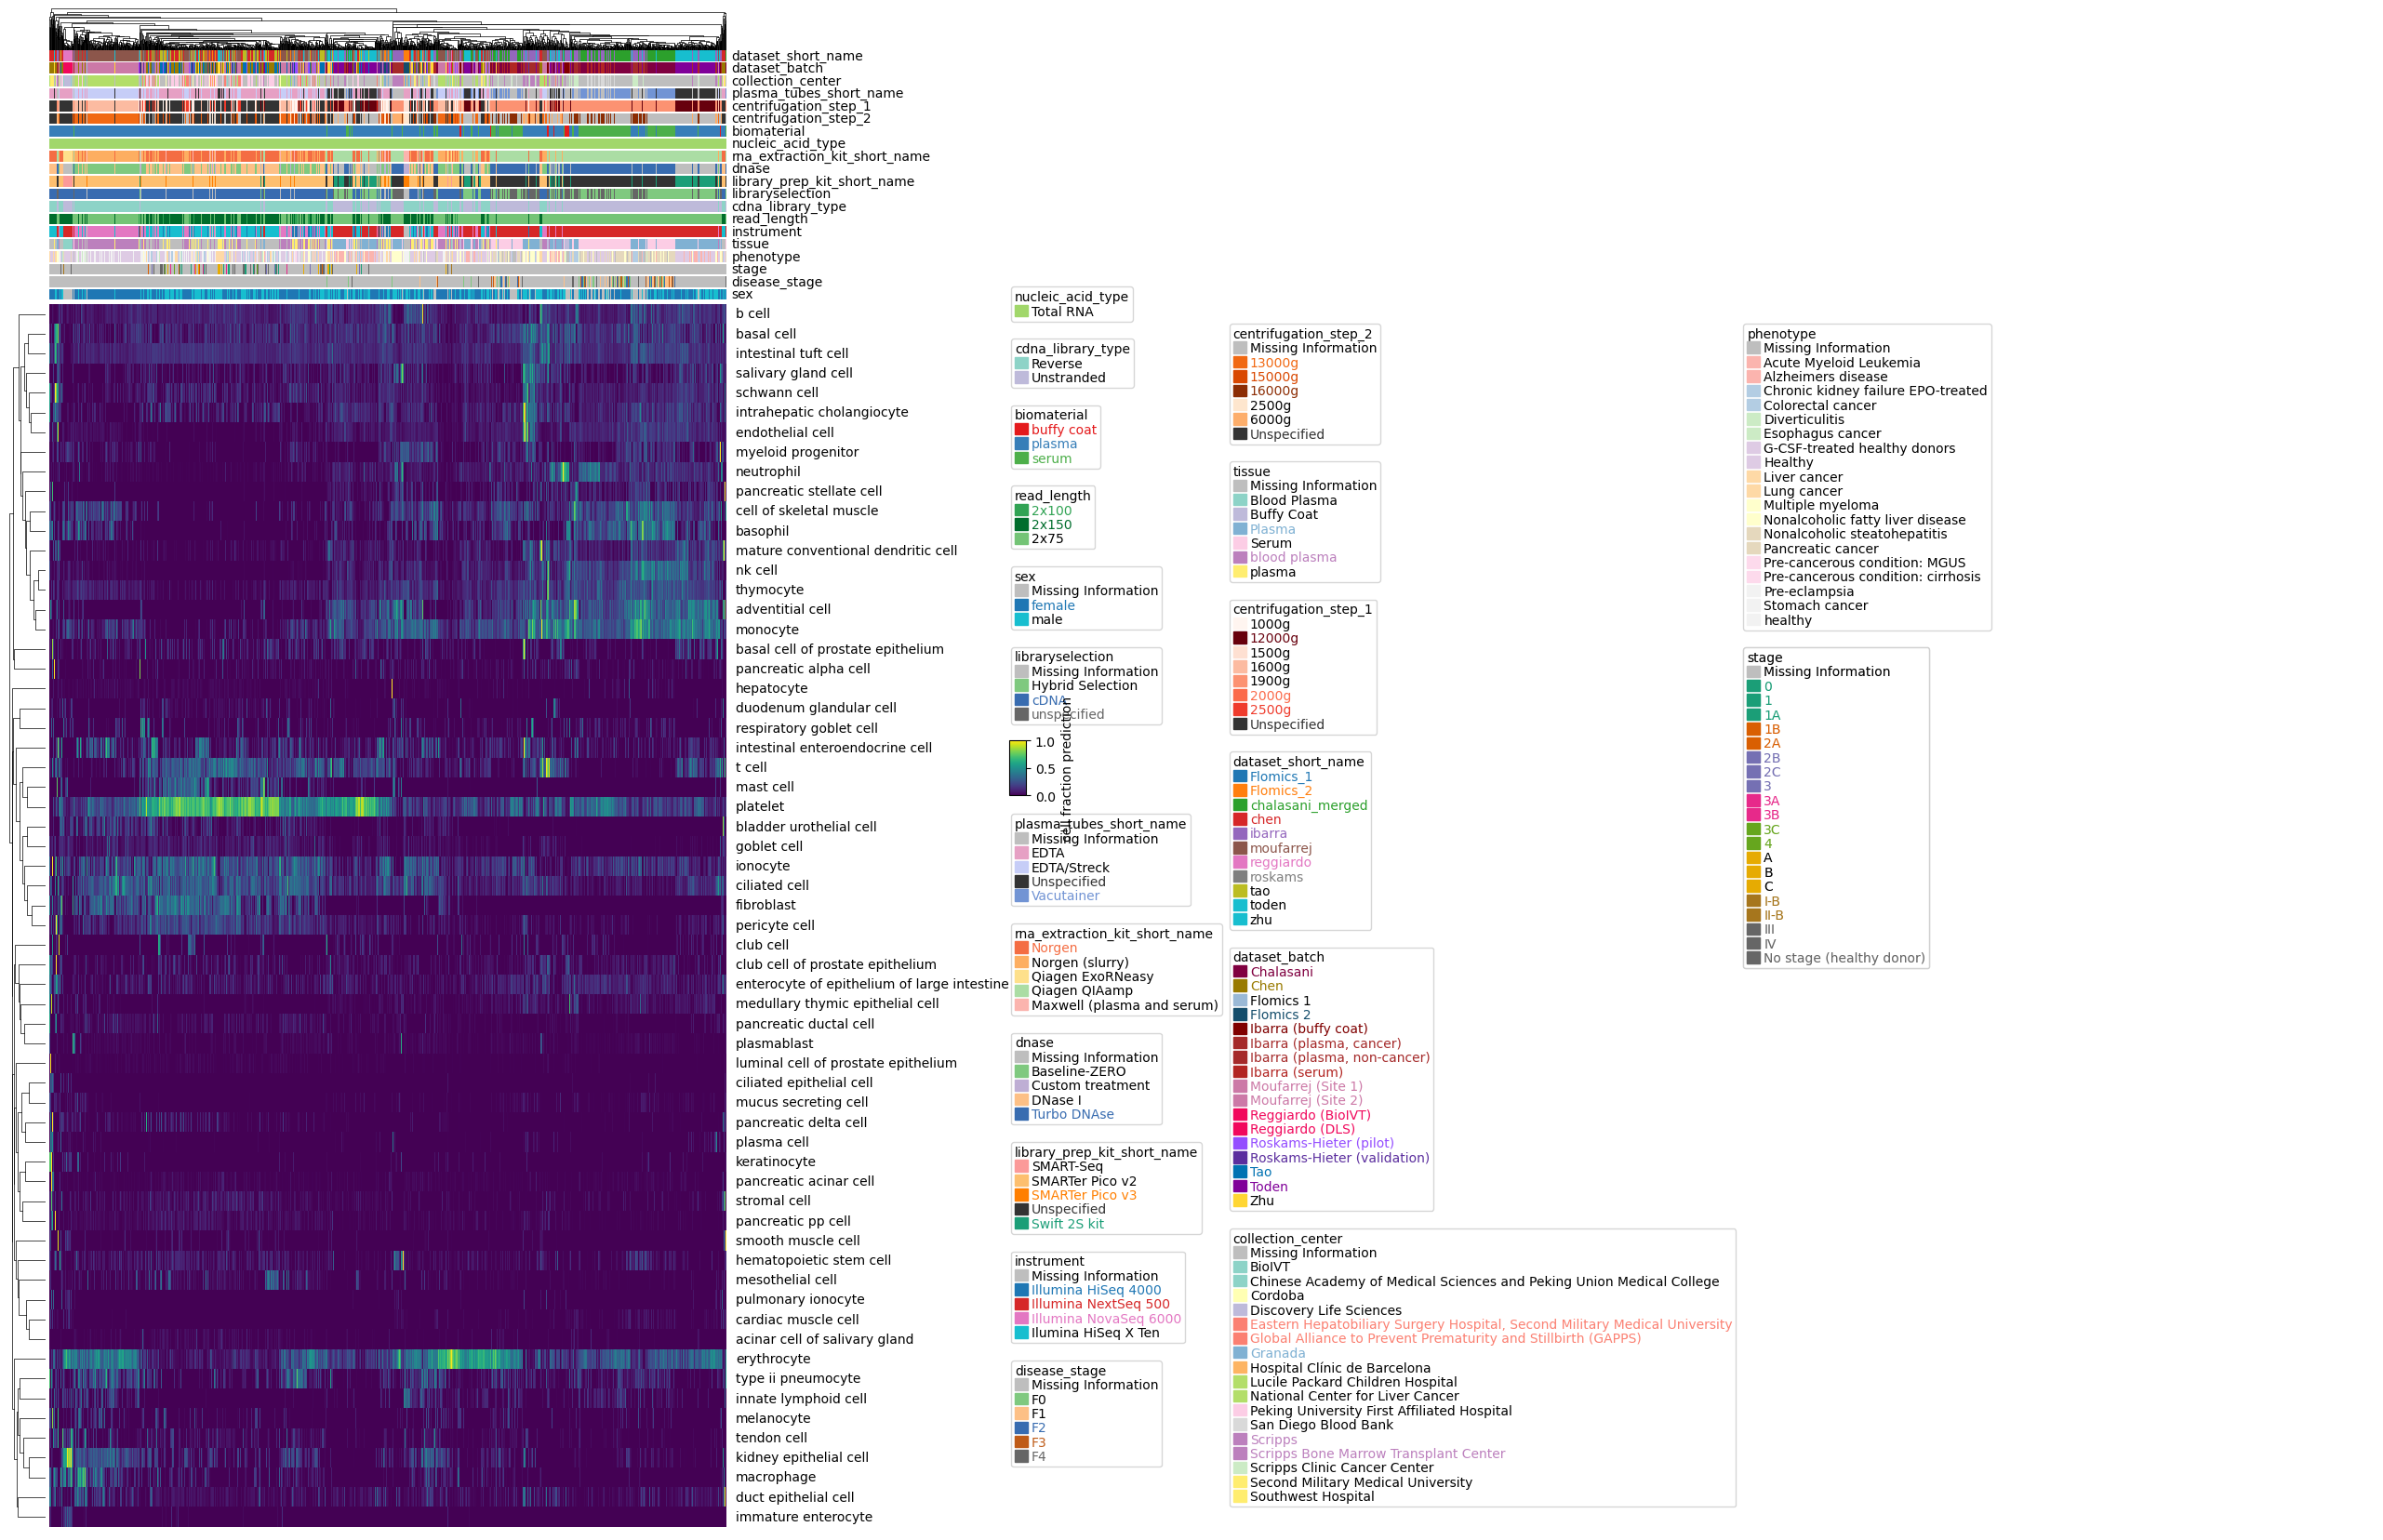

Heatmap saved to output/all_datasets/heatmap/all_cell.pdf and output/all_datasets/heatmap/all_cell.png


In [86]:
out_file = "../output/all_datasets/heatmap/all_cell"
heatmap_plot.create_heatmap(unique_dataset,
                                       all_cell_list,
                                       meta_list,
                                       metadata_colors_mapping = heatmap_color_dict,
                                       remove_all_zero=True,
                                       rescale_values=True,
                                       row_cluster=True,
                                       output=out_file)

#### all cell-types (MCTs)

{'erythrocyte', 'platelet', 'macrophage', 'monocyte', 'neutrophil', 'b cell'}
{'dataset_batch': {'Chalasani': '#800040', 'Chen': '#997a00', 'Decruyenaere': '#009E73', 'Flomics': '#144d6b', 'Ibarra (buffy coat)': '#800000', 'Ibarra (serum)': '#B22522', 'Moufarrej (Site 1)': '#CC79A7', 'Moufarrej (Site 2)': '#CC79A7', 'Reggiardo (BioIVT)': '#F1085C', 'Reggiardo (DLS)': '#F1085C', 'Tao': '#0072B2', 'Toden': '#800099', 'Zhu': '#ffd633', 'Ibarra (plasma C)': '#1f77b4', 'Ibarra (plasma NC)': '#d62728', 'Roskams (pilot)': '#e377c2', 'Roskams (validation)': '#17becf'}, 'collection_center_short_name': {'Missing Information': '#BEBEBE', 'BBSSPA': '#A6CEE3', 'BioIVT': '#1F78B4', 'Discovery Life Sciences': '#B2DF8A', 'GAPPS': '#33A02C', 'GEMs (Indiana)': '#FB9A99', 'IDIBAPS': '#E31A1C', 'LPCH': '#FDBF6F', 'NCC': '#FF7F00', 'PKUFH': '#CAB2D6', 'PUMC': '#6A3D9A', 'SMMU': '#FFFF99', 'SMMU (EHBH)': '#B15928', 'San Diego Blood Bank': '#F0027F', 'Scripps': '#666666', 'Scripps (BMT)': '#BF5B17', 'Scripps

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 43.12847222222222 mm
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
0
<class 'matplotlib.legend.Legend'>
1
<class 'matplotlib.legend.Legend'>
2
<class 'matplotlib.legend.Legend'>
3
<class 'matplotlib.legend.Legend'>
4
<class 'matplotlib.legend.Legend'>
5
<class 'matplotlib.legend.Legend'>
6
<class 'matplotlib.legend.Legend'>
7
<class 'matplotlib.legend.Legend'>
8
<class 'matplotlib.legend.Legend'>
9
<class 'matplotlib.legend.Legend'>
10
<class 'matplotlib.legend.Legend'>
11
<class 'matp

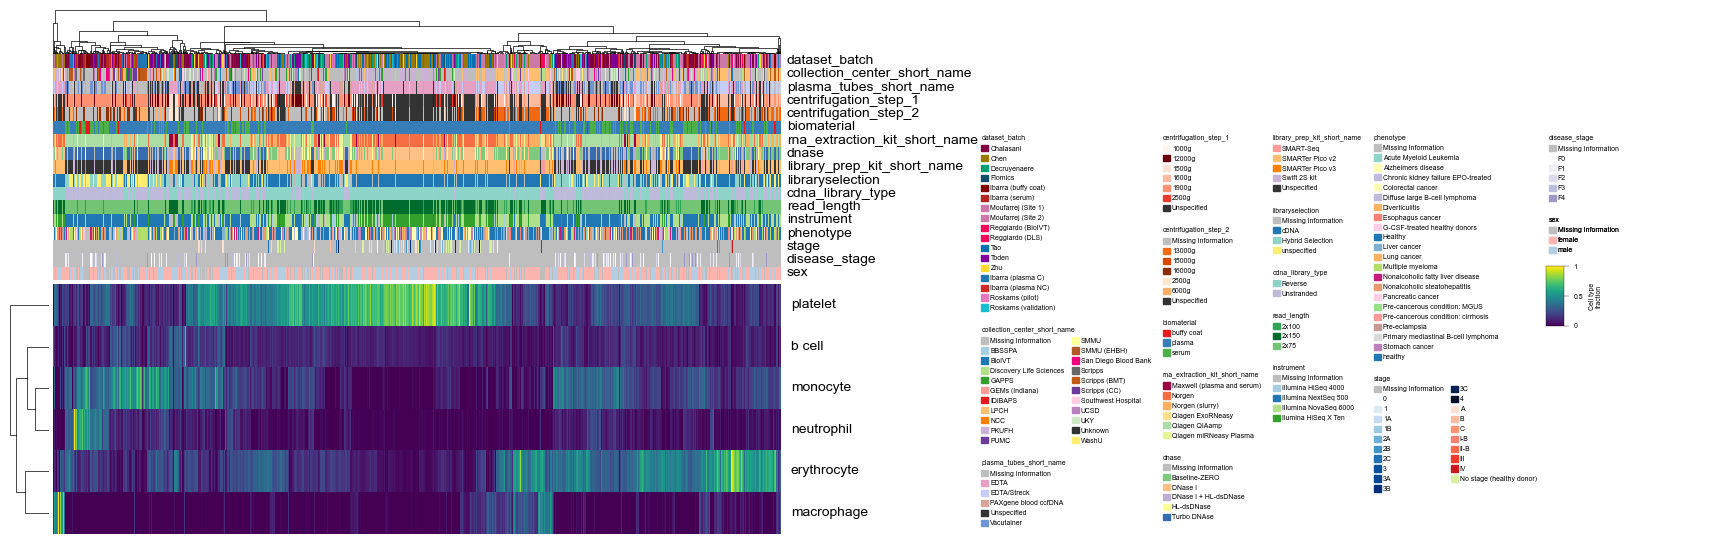

(<PyComplexHeatmap.clustermap.ClusterMapPlotter at 0x7f28201fd220>,
      dataset_batch collection_center_short_name plasma_tubes_short_name  \
 0          Flomics                       BBSSPA                    EDTA   
 1          Flomics                       BBSSPA                    EDTA   
 2          Flomics                      IDIBAPS                    EDTA   
 3          Flomics                      IDIBAPS                    EDTA   
 4          Flomics                       BBSSPA                    EDTA   
 ...            ...                          ...                     ...   
 1957  Decruyenaere          Missing Information    PAXgene blood ccfDNA   
 1958  Decruyenaere          Missing Information    PAXgene blood ccfDNA   
 1959  Decruyenaere          Missing Information    PAXgene blood ccfDNA   
 1960  Decruyenaere          Missing Information    PAXgene blood ccfDNA   
 1961  Decruyenaere          Missing Information    PAXgene blood ccfDNA   
 
      centrifugati

In [77]:
selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

print(set(selected_columns))
out_file = "../output/all_datasets/heatmap/all_cell_0.1_0.1"
heatmap_plot.create_heatmap(unique_dataset,
                                       list(set(selected_columns)),
                                       meta_list,
                                       metadata_colors_mapping = heatmap_color_dict,
                                       min_relative_abundance=0,
                                       min_sample_percentage=0,
                                       remove_all_zero=True,
                                       row_cluster=True,
                                       rescale_values=True,
                                       output=out_file)

#### only blood cells

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


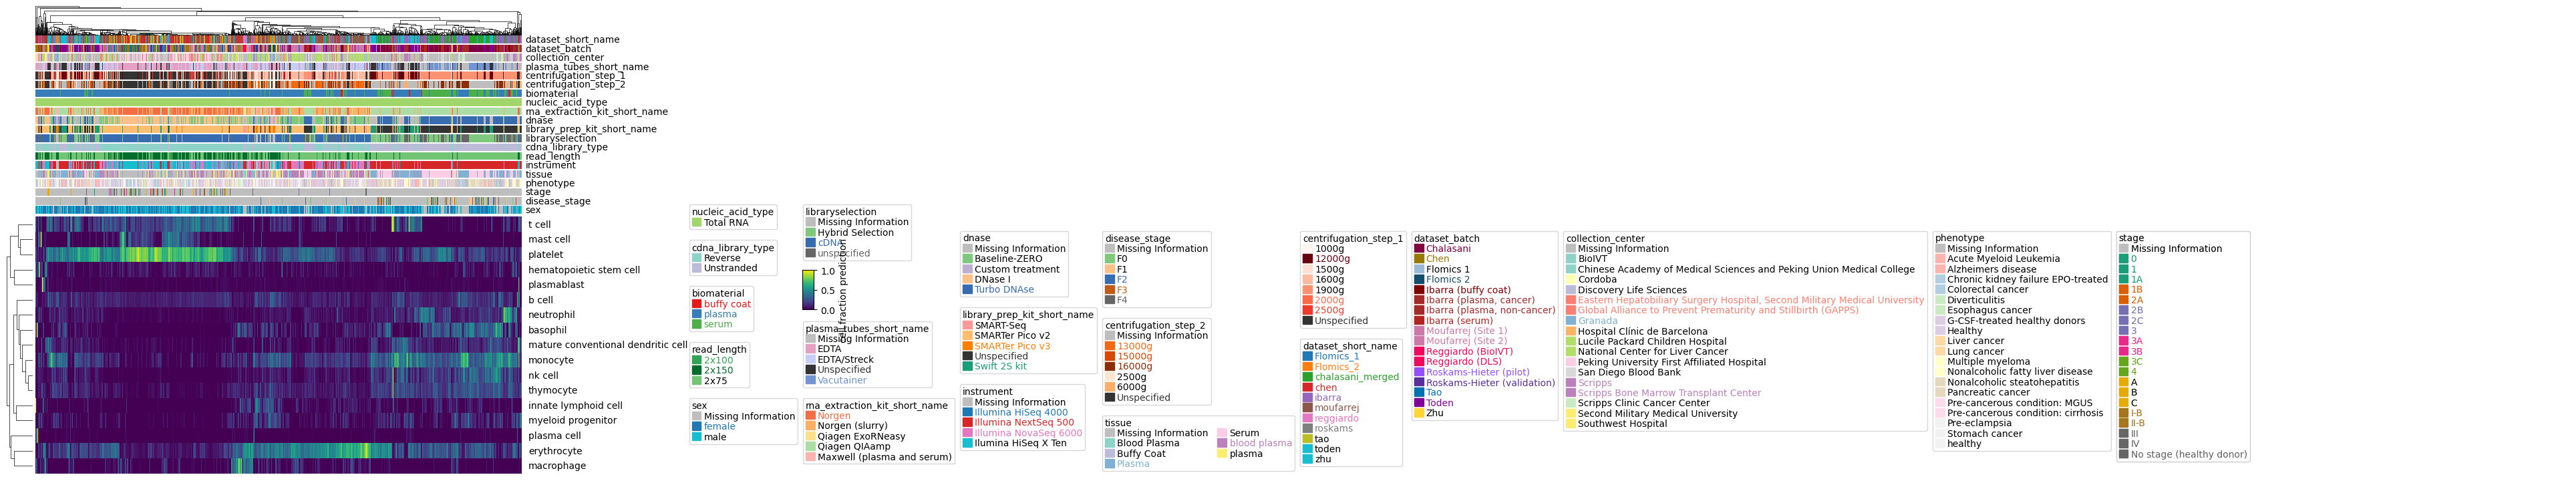

Heatmap saved to output/all_datasets/heatmap/only_blood.pdf and output/all_datasets/heatmap/only_blood.png


In [88]:
out_file = "output/all_datasets/heatmap/only_blood"
heatmap_plot.create_heatmap(unique_dataset,
                                       blood_cells,
                                       meta_list,
                                       metadata_colors_mapping = heatmap_color_dict,
                                       remove_all_zero=True,
                                       row_cluster=True,
                                       rescale_values=True,
                                       output=out_file)

#### no blood cells

/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/efs/home/gasole/miniconda3/envs/python_jupyter/lib/python3.12/site-packages/PyComplexHeatmap/clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


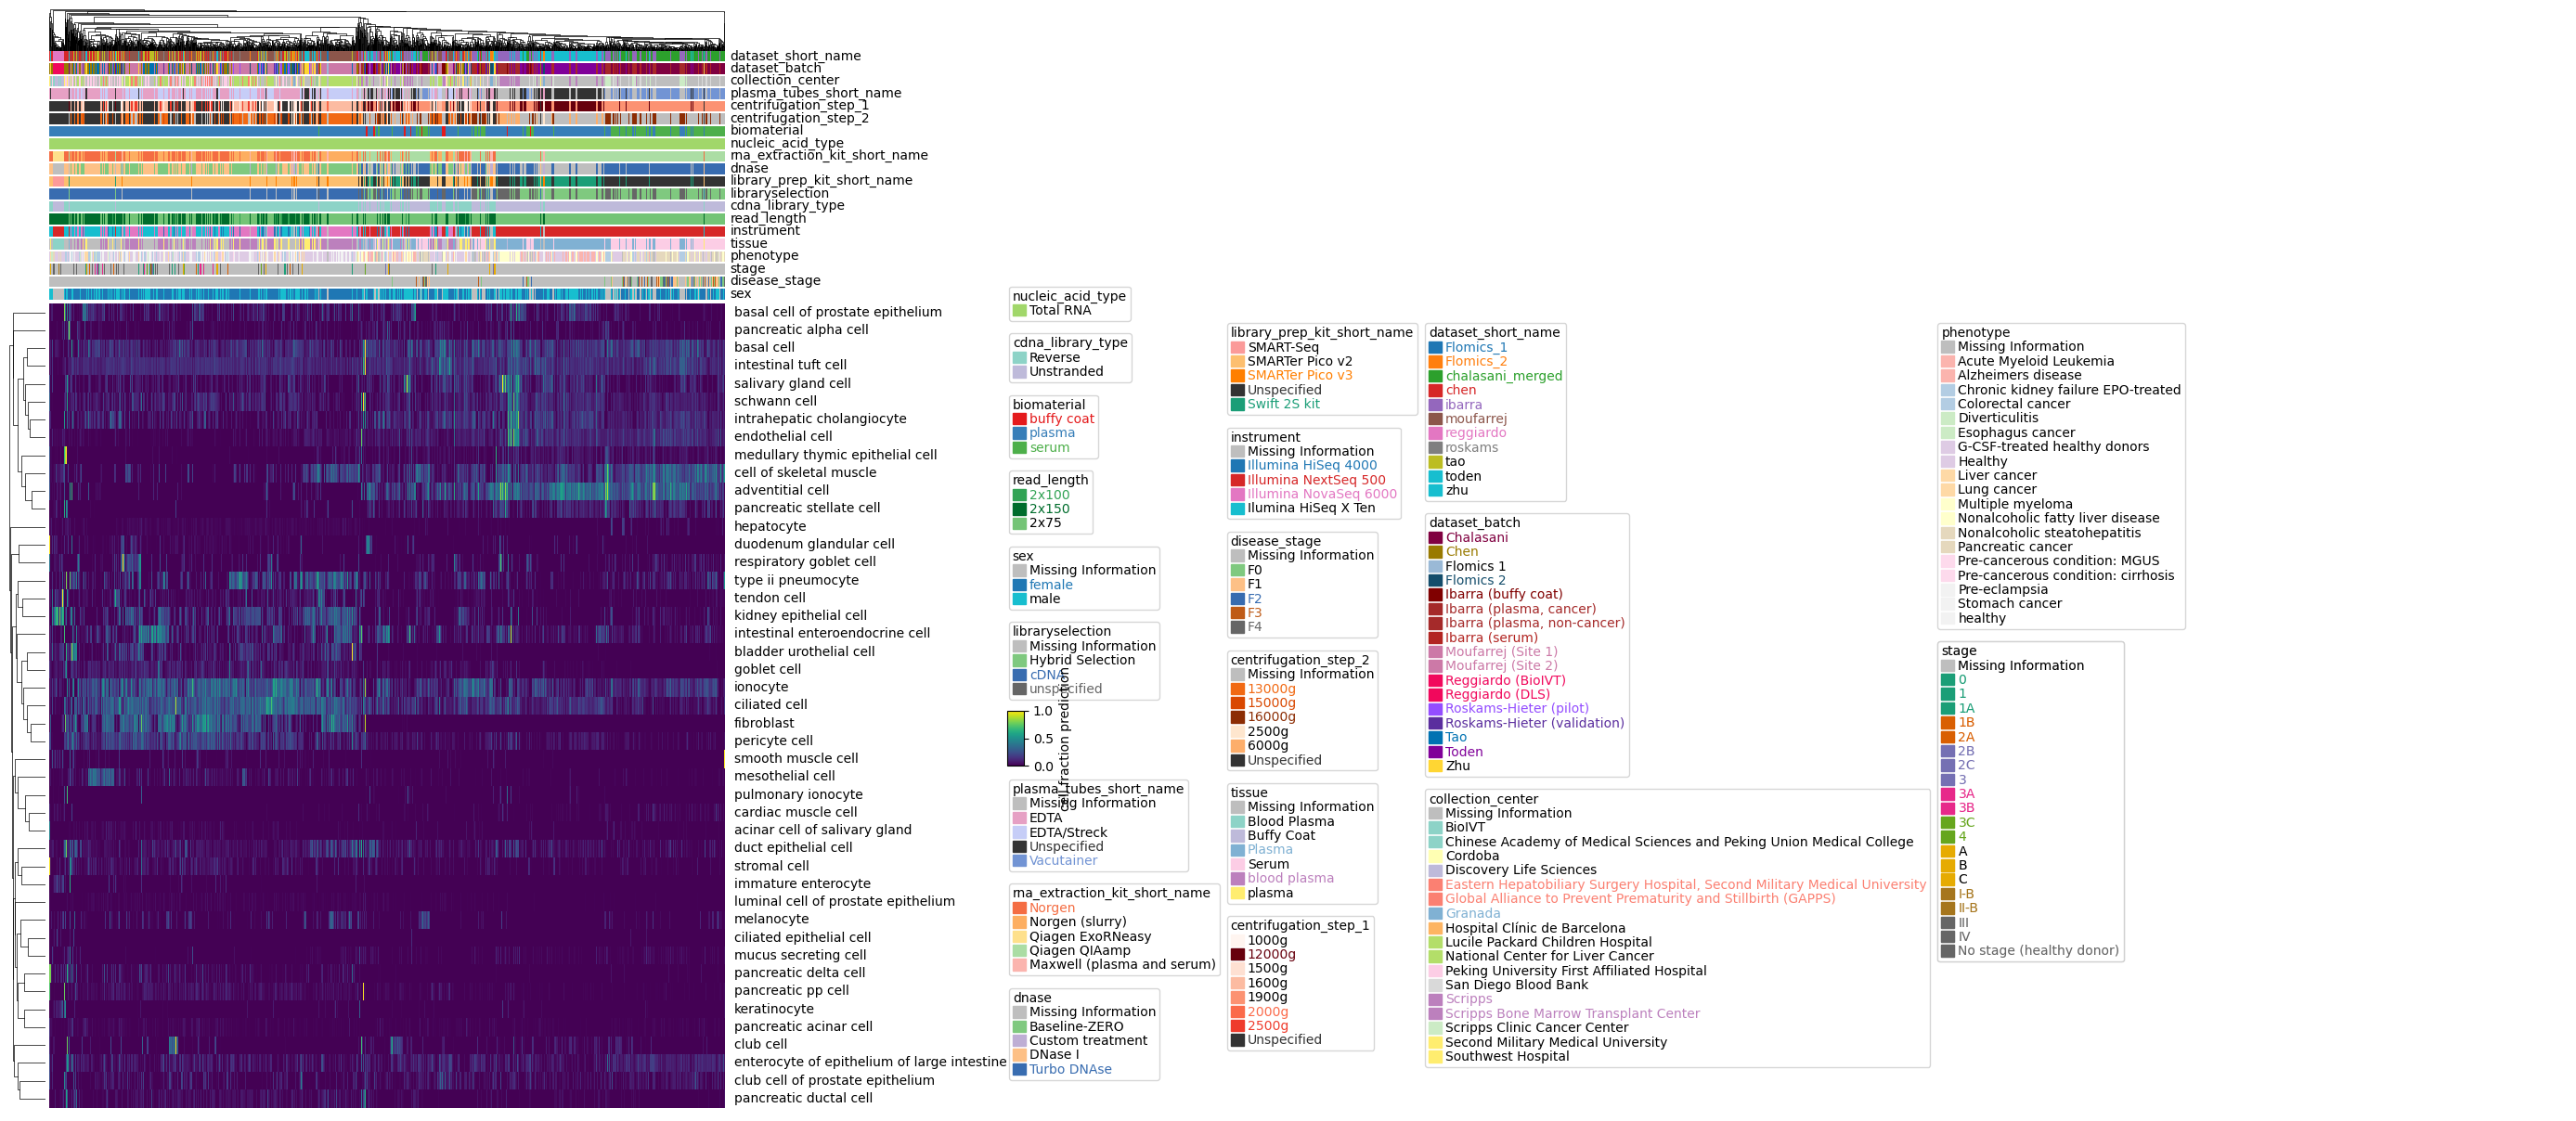

Heatmap saved to output/all_datasets/heatmap/no_blood.pdf and output/all_datasets/heatmap/no_blood.png


In [89]:
out_file = "output/all_datasets/heatmap/no_blood"
heatmap_plot.create_heatmap(unique_dataset,
                                       no_blood_cells,
                                       meta_list,
                                       metadata_colors_mapping = heatmap_color_dict,
                                       remove_all_zero=True,
                                       row_cluster=True,
                                       rescale_values=True,
                                       output=out_file)

### Bar plot

#### mean contribution and SD for MCTs

In [123]:
MCT_list = ['b cell', 'erythrocyte', 'macrophage', 'monocyte', 'platelet', 'neutrophil']

In [124]:
#create major cell types (MCTs) column
metadata_barplot['MCT']= metadata_barplot[MCT_list].sum(axis=1)

In [134]:
MCT_mean = metadata_barplot['MCT'].mean()*100
MCT_SD = metadata_barplot['MCT'].std()*100
print(f"MCT mean: {MCT_mean:.2f}")
print(f"MCT SD: {MCT_SD:.2f}")

MCT mean: 69.28
MCT SD: 12.74


#### mean contribution and SD for Erythrocyte and platelet

In [135]:
E_P_list = ['erythrocyte', 'platelet']

In [140]:
#create E_P (MCTs) column
metadata_barplot['erythrocyte_platelet']= metadata_barplot[E_P_list].sum(axis=1)

In [139]:
E_P_mean = metadata_barplot['erythrocyte_platelet'].mean()*100
E_P_SD = metadata_barplot['erythrocyte_platelet'].std()*100
print(f"erythrocyte_platelet mean: {E_P_mean:.2f}")
print(f"erythrocyte_platelet SD: {E_P_SD:.2f}")

erythrocyte_platelet mean: 56.62
erythrocyte_platelet SD: 16.89


#### mean contribution and SD for Erythrocyte and platelet In Zhu dataset batches

In [143]:
Zhu_healthy_mean = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (healthy)"]["platelet"].mean()*100
Zhu_healthy_SD = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (healthy)"]["platelet"].std()*100
print(f"Zhu (healthy) mean: {Zhu_healthy_mean:.2f}")
print(f"Zhu (healthy) SD: {Zhu_healthy_SD:.2f}")

Zhu (healthy) mean: 8.88
Zhu (healthy) SD: 7.36


In [145]:
Zhu_cancer_mean = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (Cancer)"]["platelet"].mean()*100
Zhu_cancer_SD = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (Cancer)"]["platelet"].std()*100
print(f"Zhu (cancer) mean: {Zhu_cancer_mean:.2f}")
print(f"Zhu (cancer) SD: {Zhu_cancer_SD:.2f}")

Zhu (cancer) mean: 55.78
Zhu (cancer) SD: 14.48


In [85]:
zhu_healthy = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (healthy)"]["platelet"]
zhu_cancer = metadata_barplot[metadata_barplot["dataset_batch_custom"] == "Zhu (Cancer)"]["platelet"]
U1, p = mannwhitneyu(zhu_healthy,zhu_cancer)
print(U1)
print(p)
nx, ny = len(zhu_healthy), len(zhu_cancer)
U2 = nx*ny - U1
print(U2)

4.0
7.42240782375193e-12
1046.0


### Barplot

#### set order 

In [37]:
order_label_1 = [
 'Chalasani',
 'Ibarra (buffy coat)',
 'Ibarra (plasma C)',
 'Ibarra (plasma NC)',
 'Ibarra (serum)',
 'Toden',
 'Reggiardo (BioIVT)',
 'Reggiardo (DLS)',
 'Block (2x75bp)',
 'Block (2x150bp)',
 'Chen (Peking University)',
 'Chen (Others)',
 'Decruyenaere',
 'Flomics (Cordoba)',
 'Flomics (Others)',
 'Moufarrej (Site 1)',
 'Moufarrej (Site 2)',
 'Roskams (pilot)',
 'Roskams (validation)',
 'Tao',
 'Zhu (Cancer)',
 'Zhu (healthy)']

#### group dictionaries

In [ ]:
dataset_group_dict = {
    'Custom': 'Custom',
    'cfDNA': 'cfDNA',
    'Exome-based (EB)': 'EB',
    'Whole RNA-Seq (oligo-dT pr.) (WRO)': 'WRO',
    'Whole RNA-Seq (random pr.) (WRR)': 'WRR'}

dataset_group_color = {
    'Custom': '#D9BBAE',
    'cfDNA': '#AECAD9' ,
    'EB': '#BBE0BB',
    'WRO': '#D0AED9',
    'WRR': '#D9D6AE'}

#### Final bar plot (MCTs) ~ personalized legend

['erythrocyte', 'macrophage', 'neutrophil', 'b cell', 'platelet', 'monocyte']
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V1.pdf
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V1.png
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V1.svg


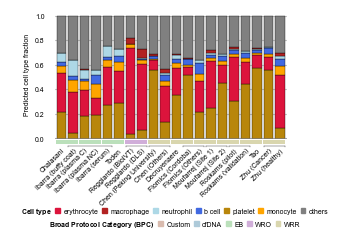

In [41]:
reload(barplot_stacked_plot)

dataset_group_dict = {
    'Custom': 'Custom',
    'cfDNA': 'cfDNA',
    'Exome-based (EB)': 'EB',
    'Whole RNA-Seq (oligo-dT pr.) (WRO)': 'WRO',
    'Whole RNA-Seq (random pr.) (WRR)': 'WRR'}

dataset_group_color = {
    'Custom': '#D9BBAE',
    'cfDNA': '#AECAD9' ,
    'EB': '#BBE0BB',
    'WRO': '#D0AED9',
    'WRR': '#D9D6AE'}

metadata_barplot["broad_protocol_category_short"] = metadata_barplot["broad_protocol_category"].replace(dataset_group_dict)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)
#create stacked barplot for merged dataset
out_file = "../output/all_datasets/barplot/dataset_short_name_"+str(min_relative_abundance)+"_"+str(min_sample_percentage)+"_V1"

df1, df2, ax, artist_elements = barplot_stacked_plot.create_stacked_barplot(
                       #basic data input
                       dataset = metadata_barplot,
                       meta_column = "dataset_batch_custom",
                       meta_order = order_label_1,
                       value_columns = all_cell_list,
                       value_order = 'median_descending',
                       output = out_file,
                       dpi = 600,
                       #scaling
                       scaling = "mean",
                       #normalizing
#                       normalize_data = True,
                       #focus values
                       focus_value = selected_columns,
                       color_map = cell_type_colors_dark,
                       #borders
                       add_category_border = True,
                       category_border_width = 0.25,
                       #grouping
                       group_by_column = "dataset_short_name",
                       show_group_label = False,
                       group_label_fontsize = 8,
                       group_label_y_offset    = -0.065,
                       group_bracket_linewidth = 0.25,
                       group_bracket_vertical_line_length = 0.01,
                       group_bracket_horizontal_line_length = 0.4,
                       group_position = 'middle',
                       #shades
                       add_connecting_shades = False,
                       #plot visualization
                       ylabel = "Predicted cell type fraction",
                       xlabel_fontsize = 5,
                       ylabel_fontsize = 5,
                       x_tick_label_fontsize = 5,
                       x_tick_label_rotation = 45,
                       x_ticks_label_pad = -0.03,
                       yticks = [0,0.2,0.4,0.6,0.8,1],
                       y_tick_label_fontsize = 5,
                       show_xlabel = False,
                       show_title = False,
                       fig_width = 4.4,
                       fig_height = 2,
                       hide_top_spine = True,
                       hide_right_spine = True,
                       legend_title = "Cell type",
                       #legend
                       #legend_position = "custom bottom",
                       legend_x_pos = 1.05,
                       legend_y_pos = -0.65,
                       legend_title_fontsize = 5,
                       legend_fontsize = 5,
                       # boxes
                       boxes_column = "broad_protocol_category_short",
                       boxes_color_map = dataset_group_color,
                       boxes_y_position = -0.04,
                       boxes_height = 0.03,
                       boxes_width = 0.95,
                       boxes_legend = True,
                       hide_bottom_spine= True,
                       hide_left_spine = True,
                       hide_bottom_tick = True,
                       hide_left_tick = True,
                       boxes_borderwidth = 0,
                       #boxes_legend_pos = "bottom",
                       boxes_legend_y_pos  = -0.75,
                       boxes_legend_title = "Broad Protocol Category (BPC)",
                       boxes_legend_fontsize = 5,
                       # layout
                       ax_width = 1.01*2.3,
                       aspect = 1.8,   # tweak as pleased
                       )

#### Final bar plot (MCTs) ~ default legend

['erythrocyte', 'macrophage', 'neutrophil', 'b cell', 'platelet', 'monocyte']
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V2.pdf
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V2.png
Box plot saved to output/all_datasets/barplot/dataset_short_name_0.1_0.1_V2.svg


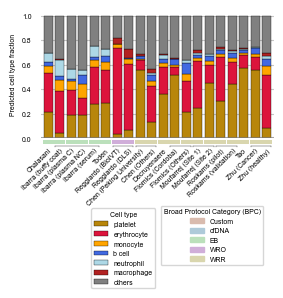

In [52]:
reload(barplot_stacked_plot)

metadata_barplot["broad_protocol_category_short"] = metadata_barplot["broad_protocol_category"].replace(dataset_group_dict)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)
#create stacked barplot for merged dataset
out_file = "../output/all_datasets/barplot/dataset_short_name_"+str(min_relative_abundance)+"_"+str(min_sample_percentage)+"_V2"

df1, df2, ax, artist_elements = barplot_stacked_plot.create_stacked_barplot(
                       #basic data input
                       dataset = metadata_barplot,
                       meta_column = "dataset_batch_custom",
                       meta_order = order_label_1,
                       value_columns = all_cell_list,
                       value_order = 'median_descending',
                       output = out_file,
                       dpi = 600,
                       #scaling
                       scaling = "mean",
                       #normalizing
#                       normalize_data = True,
                       #focus values
                       focus_value = selected_columns,
                       color_map = cell_type_colors_dark,
                       #borders
                       add_category_border = True,
                       category_border_width = 0.25,
                       #grouping
                       group_by_column = "dataset_short_name",
                       show_group_label = False,
                       group_label_fontsize = 8,
                       group_label_y_offset    = -0.065,
                       group_bracket_linewidth = 0.25,
                       group_bracket_vertical_line_length = 0.01,
                       group_bracket_horizontal_line_length = 0.4,
                       group_position = 'middle',
                       #shades
                       add_connecting_shades = False,
                       #plot visualization
                       ylabel = "Predicted cell type fraction",
                       xlabel_fontsize = 5,
                       ylabel_fontsize = 5,
                       x_tick_label_fontsize = 5,
                       x_tick_label_rotation = 45,
                       x_ticks_label_pad = -0.03,
                       yticks = [0,0.2,0.4,0.6,0.8,1],
                       y_tick_label_fontsize = 5,
                       show_xlabel = False,
                       show_title = False,
                       fig_width = 4.4,
                       fig_height = 2,
                       hide_top_spine = True,
                       hide_right_spine = True,
                       legend_title = "Cell type",
                       #legend
                       legend_position = "center",
                       legend_x_pos = 0.2,
                       legend_y_pos = -0.85,
                       legend_title_fontsize = 5,
                       legend_fontsize = 5,
                       # boxes
                       boxes_column = "broad_protocol_category_short",
                       boxes_color_map = dataset_group_color,
                       boxes_y_position = -0.04,
                       boxes_height = 0.03,
                       boxes_width = 0.95,
                       boxes_legend = True,
                       hide_bottom_spine= True,
                       hide_left_spine = True,
                       hide_bottom_tick = True,
                       hide_left_tick = True,
                       boxes_borderwidth = 0,
                       boxes_legend_pos = "center",
                       boxes_legend_x_pos = 0.5, 
                       boxes_legend_y_pos = -0.75,
                       boxes_legend_title = "Broad Protocol Category (BPC)",
                       boxes_legend_fontsize = 5,
                       # layout
                       ax_width = 1.01*2.3,
                       aspect = 1.8,   # tweak as pleased
                       )

### Box plot (MCTs)

['platelet', 'neutrophil', 'erythrocyte', 'b cell', 'macrophage', 'monocyte']


<string>:218: UserWarning: The following values in 'meta_order' were not found in 'dataset_batch_custom' and will be ignored: ['Block (2x75bp)', 'Block (2x150bp)']


Box plot saved to output/all_datasets/box_plots/AAA_dummy_legend_test_V1.pdf
Box plot saved to output/all_datasets/box_plots/AAA_dummy_legend_test_V1.png
Box plot saved to output/all_datasets/box_plots/AAA_dummy_legend_test_V1.svg


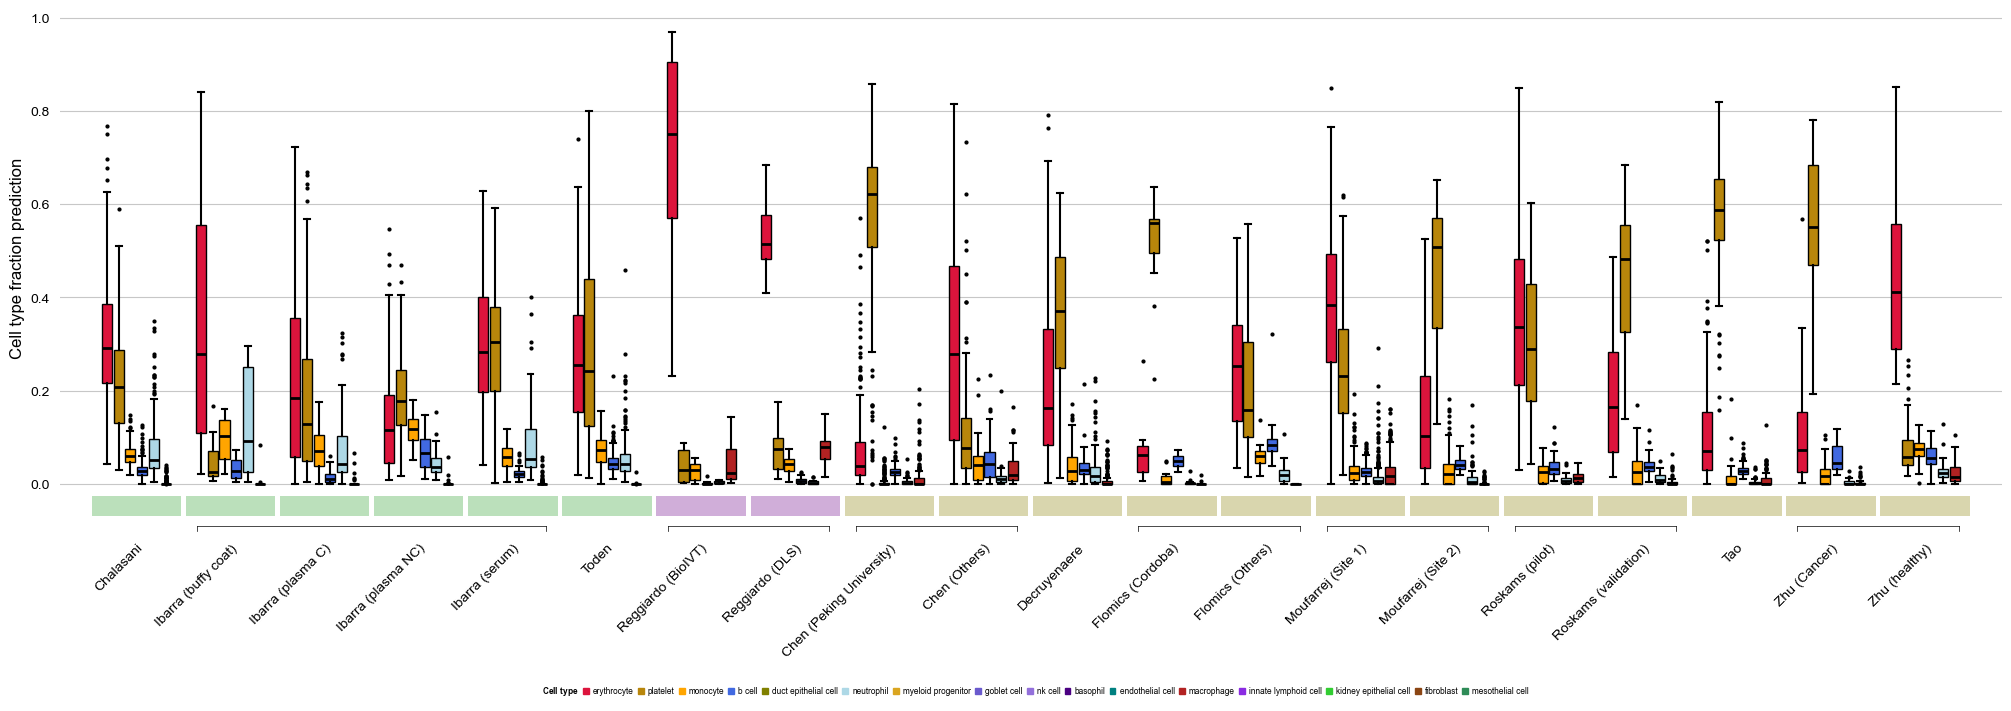

In [102]:
reload(boxplot)

metadata_barplot["broad_protocol_category_short"] = metadata_barplot["broad_protocol_category"].replace(dataset_group_dict)

selected_columns = []
min_relative_abundance=0.1
min_sample_percentage=0.1
value_columns = all_cell_list

for i in full_list:
    filtered_value_columns = []
    df = df_dict[i]
    num_samples = len(df)
    if num_samples == 0:
        print("Warning: DataFrame is empty, no filtering possible for value columns.")

    for col in value_columns:
        samples_meeting_abundance = (df[col] >= min_relative_abundance).sum()
        percentage_of_samples = samples_meeting_abundance / num_samples

        if percentage_of_samples >= min_sample_percentage:
            filtered_value_columns.append(col)
    
    if not filtered_value_columns:
        print(f"Warning: No value columns remain after filtering with min_relative_abundance={min_relative_abundance} and min_sample_percentage={min_sample_percentage}.")
    
    selected_columns.extend(filtered_value_columns) # Update value_columns after initial filtering

selected_columns = list(set(selected_columns))
print(selected_columns)
#create stacked barplot for merged dataset
out_file = "../output/all_datasets/boxplot/dataset_short_name_"+str(min_relative_abundance)+"_"+str(min_sample_percentage)+"_V1"


boxplot.create_boxplot(dataset = metadata_barplot,
                   meta_column = "dataset_batch_custom",
                   value_column = selected_columns,
                   hue_column = None,
                   meta_order = order_label_1,
                   hue_order = ["erythrocyte","platelet","monocyte","b cell","neutrophil","macrophage"],
                   color_map = cell_type_colors_dark,
#                   add_swarmplot: bool = False,
#                   swarm_size: float = 3,
#                   swarm_alpha: float = 0.5,
#                   swarm_color: str = 'black',
#                   box_width: float = 0.6,
#                   whisker_capsize: float = 0.05,
#                   show_outliers: bool = True,
                   outlier_marker = ".",
                   outlier_size = 4,
                   outlier_alpha = 1,
                   notch = False,
#                   median_color: str = 'red',
#                   median_linewidth: float = 2,
#                   mean_marker: str = 'D',
#                   mean_marker_size: float = 8,
#                   mean_marker_color: str = 'green',
#                   show_mean: bool = False,
                   group_by_column = "dataset_short_name",
                   group_position = 'middle',
                   group_spacing = 0,
#                   group_label_rotation: float = 0,
#                   group_label_fontsize: int = 12,
                   group_label_y_offset = -0.05,
                   group_bracket_linewidth = 0.5,
                   group_bracket_vertical_line_length = 0.01,
                   group_bracket_horizontal_line_length = 2,
                   fig_width = 20,
                   fig_height = 7,
                   output = out_file,
                   show_xlabel = False,
#                   show_ylabel: bool = True,
                   show_title = False,
#                   title: str = None,
#                   title_pad: float = 10,
#                   title_fontsize: float = 14,
                   ylabel = "Cell type fraction prediction",
#                   ylabel: str = None,
#                   xlabel_fontsize: float = 12,
                   xlabel_rotation = 45,
                   xticks_label_pad = -0.06,
                   hide_top_spine = True,
                   hide_right_spine = True,
                   legend_title = "Cell type",
#                   ylabel_fontsize: float = 12,
#                   xticks_fontsize: float = 10,
#                   yticks_fontsize: float = 10,
                   show_group_label = False,
#                   legend_title: str = None,
#                   legend_y_pos: float = 0.5,
                   legend_x_pos = 1.025,
                   y_upper_pad = 0.05,
                   #boxes
                   boxes_column = "broad_protocol_category_short",
                   boxes_color_map = dataset_group_color,
                   boxes_y_position = - 0.02,
                   boxes_height = 0.04,
                   boxes_width = 0.95,
                   boxes_legend = True,
                   hide_bottom_spine= True,
                   hide_left_spine = True,
                   hide_bottom_tick = True,
                   hide_left_tick = True,
                   boxes_borderwidth = 0,
                   boxes_legend_pos = "bottom",
                   boxes_legend_y_pos = -0.5,
                   boxes_legend_title = "broad protocol category (BPC)",
                   boxes_legend_fontsize = 6
                           )